### 창업계획서 초안 작성

In [3]:
from getpass import getpass
from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

from langchain.chains import LLMChain
# ConversationBufferMemory : 챗봇이 이전의 대화 내용을 기억할 수 있게 해주는 클래스
 # 사용하면 LLM에 질의를 넘겨줄 때 이전 대화도 같이 넘겨주게 됨
 # (단 이러한 memory클래스는 모델별로 최대 입력 토큰의 제약이 있어서 적절히 사용해야함)
from langchain.memory import ConversationBufferMemory
# ConversationBufferMemory : 챗봇이 이전의 대화 내용을 기억할 수 있게 해주는 클래스
 # 모든 대화 내용을 저장하지 않고 메모리와 토큰을 효율적으로 관리하고 싶을 때 사용
from langchain.memory import ConversationBufferWindowMemory  # 대화 몇 개까지 저장할꺼냐 지정할 수 있는 클래스

In [4]:
import json
import os
from openai import OpenAI

In [5]:
from getpass import getpass

In [6]:
MY_API_KEY = getpass("OpenAi API Key:")

In [7]:
client = OpenAI(api_key=MY_API_KEY)

In [8]:
from langchain.document_loaders import JSONLoader

#### 공통 프롬프트

In [95]:
prompt1 = """
당신은 기존 창업가의 아이디어를 구체화하고 사업 가능성을 검증하는 사업계획서 작성 전문가입니다. 
이 사업계획서는 고객의 생계가 달린 아주 중요한 작업입니다.
{ai_prompt1}을 참고하여 아래 두 질문에 각각 15줄 이상 상세히 답변해주세요. 
반드시 답변마다 별도의 문단을 생성하고, 간결함보다 완전성을 우선시합니다
아이디어 검증 및 사업 구체화를 위한 사업계획서에서 제품 및 서비스 개발동기와 제품 및 서비스의 목적(필요성)만 작성해 주세요.
관련된 정보를 더 찾아서 사업아이템을 구체화해줘도 좋습니다.
'특히' 또는 '결론적으로' 같은 단어가 있다면 줄바꿈을 해주세요.

사업계획서 해당 문항을 작성할 때 아래의 작성 TIP을 참고해서 작성해 주세요. 
아래 TIP은 정부지원사업 담당자가 알려준 내용이며, 참고할 경우 합격률을 대폭 늘릴 수 있습니다.
관련 기사 및 논문을 서치하여 참고하겨 구체적인 사례와 수치를 제시하면 계획서의 근거와 신뢰성이 상승합니다. 

사용자 정보 : {item_info}
템플릿 양식 : {kosme_template}
참고 : {kosme_pass}
"""

#### 1번 문항 프롬프트

In [90]:
ai_prompt1 = """
✅ **[제품 및 서비스 개발동기와 제품 및 서비스의 목적(필요성) 작성 시 필수 반영 요소]**  
1️⃣ **시장성:**  
   - 현재 산업의 규모, 성장률, 경쟁 환경 및 시장 점유율 분석  
   - 주요 타겟 고객층(기업, 정부, 개인 소비자 등) 및 소비 트렌드 반영  
   - 국내 및 글로벌 시장 비교하여 확장 가능성 검토  
   - 경쟁사와의 차별성 분석 (유사 서비스, 기존 방식과의 비교)  

2️⃣ **법적 근거:**  
   - 관련 법률 및 규제 (ex. 산림보호법, 환경규제 등) 명시  
   - 정부 정책 및 지원 프로그램과의 연계성 검토  
   - 법적 준수 사항 및 산업 내 필수 인증 절차 포함  

3️⃣ **실현 가능성:**  
   - 현재 기술 개발 상태 및 향후 로드맵  
   - 시제품 출시 및 실증 테스트(CBT, PoC 등) 진행 여부  
   - 협력 기업, 연구소, 공공기관 등과의 파트너십 및 협업 내용  

"""


#### 2번 문항 프롬프트

In [91]:
ai_prompt2 = """
2. 실현가능성

1) 제품(서비스) 구현정도 
    - 제품(서비스) 구현정도, 제작 소요기간 및 제작방법(자체,외주)작성해 주세요.
    - 구체화할 제품 또는 서비스의 핵심 기능, 성능, 디자인, 기타 활동을 통해 세부적인 개발 및 구체화 방안, 최종 산출물 등을 작성하세요.
    - 보유역량을 기반으로 경쟁자와의 차별화 요인을 설명하되, 스펙, 핵심 기능, 성능, 고객 제공 혜택 등 다양한 측면에서 표현해주세요.
    - 차별화를 실현할 수 있는 보유역량은 특허 등(구성, 공정 등) 물리적 역량뿐만 아니라 콘텐츠 등 소프트웨어적 역량도 모두 포함해주세요.

1-2) 사업 추진일정
    - 현재 날짜 기준으로 사업 추진일정을 분기별로 작성해 주세요. 그리고 (예시)를 붙여주세요.
     
2) 사업의 차별점
    - 경쟁사 분석을 도와주세요. 
    - 비슷한 사업 아이템을 가진 경쟁사를 찾고, 강점, 약점, 전략을 분석해 주세요.   
             
             
             사업 아이디어 구체화 : 내 사업 아이디어를 구체화 해줘. 그리고 '아이템 명', '아이템 소개' 기반으로 '예상 고객' 부분을 작성해줘.
             시장 분석 : 사업에 필요한 시장분석을 도와줘. '아이템 소개' 기반으로 해당 아이템과 관련된 산업/제품의 '시장 분석' 부분을 작성해줘. 또한 트렌드와 '경쟁사 분석' 부분을 작성해줘.
             목표 설정 : 사업의 SMART 목표를 설정할 수 있도록 도와줘. [사업 분야]의 구체적이고 실현 가능한 목표를 제안해 줘.
             """

#### 3번 문항 프롬프트

In [92]:
ai_prompt3 = """
3. 성장전략(scale-up)
1) 자금소요 및 조달계획
    - 자금의 필요성, 금액의 적정성 여부를 판단할 수 있도록 사업비(정부지원금+대응자금)의 사용계획 등을 기재(신청사업의 통합관리지침 및 세부관리기준에 근거하여)하여 작성해 주세요

2) 시장진입 및 성과창출 전략
2-1) 내수시장 확보 방안(경쟁 및 판매가능성) 
    - 내수시장을 중심으로 주 소비자층, 주 타겟시장, 진출시기, 시장진출 및 판매 전략, 그간 실적 등을 구체적으로 작성해 주세요. 

2-2) 해외시장 진출 방안(경쟁 및 판매가능성)
    - 해외시장을 중심으로 주 소비자층, 주 타겟시장, 진출시기, 시장진출 및 판매 전략, 그간 실적 등을 구체적으로 작성해 주세요.

"""

### 청년창업사관학교 전용 템플릿

In [ ]:
import json
import os

# 사용자 입력 받기
아이템_명 = input('아이템 명을 입력하세요: ')
아이템_소개 = input('아이템 소개를 입력하세요: ')
제품_및_서비스_개발동기 = input('제품 및 서비스 개발동기를 입력하세요: ')
제품_및_서비스의_목적_필요성 = input('제품 및 서비스의 목적(필요성)을 입력하세요: ')
제품_및_서비스의_개발_방안 = input('제품 및 서비스의 개발 방안을 입력하세요: ')
자금_조달_및_개발_방안 = input('자금 조달 및 개발 방안을 입력하세요: ')
내수시장_확보_방안_경쟁_및_판매가능성 = input('내수시장 확보 방안(경쟁 및 판매가능성)을 입력하세요: ')
해외시장_진출_방안_경쟁_및_판매가능성 = input('해외시장 진출 방안(경쟁 및 판매가능성)을 입력하세요: ')
대표자_및_직원의_보유역량_및_기술보호_노력 = input('대표자 및 직원의 보유역량 및 기술보호 노력을 입력하세요: ')
사회적_가치_실천계획 = input('사회적 가치 실천계획을 입력하세요: ')
지역특화_아이디어_기반_사업추진계획 = input('지역특화 아이디어 기반 사업추진계획을 입력하세요: ')
타겟_고객 = input('타겟 고객: ')
시장_규모 = input('시장 규모을 입력하세요: ')
경쟁사_분석 = input('경쟁사 분석을 입력하세요: ')

# 입력된 내용을 딕셔너리에 저장
item_info = {
    '아이템 명': 아이템_명,
    '아이템 소개': 아이템_소개,
    '제품 및 서비스 개발동기': 제품_및_서비스_개발동기,
    '제품 및 서비스의 목적_필요성': 제품_및_서비스의_목적_필요성,
    '제품 및 서비스의 개발 방안': 제품_및_서비스의_개발_방안,
    '자금 조달 및 개발 방안': 자금_조달_및_개발_방안,
    '내수시장 확보 방안 경쟁 및 판매가능성': 내수시장_확보_방안_경쟁_및_판매가능성,
    '해외시장 진출 방안 경쟁 및 판매가능성': 해외시장_진출_방안_경쟁_및_판매가능성,
    '대표자 및 직원의 보유역량 및 기술보호 노력': 대표자_및_직원의_보유역량_및_기술보호_노력,
    '사회적 가치 실천계획': 사회적_가치_실천계획,
    '지역특화 아이디어 기반 사업추진계획': 지역특화_아이디어_기반_사업추진계획,
    '타겟 고객': 타겟_고객,
    '시장 규모': 시장_규모,
    '경쟁사 분석': 경쟁사_분석
}




입력된 정보가 고객 사업정보\OCS 기반 수목의료용 케미컬 및 자재 커머스 O2O 플랫폼 사업계획서.jsonl 파일에 저장되었습니다.


In [146]:
kosme_template = {f'''

1. 문제 인식  
1) 제품 및 서비스 개발동기
(자사가 개발(보유)하고 있는 제품 및 서비스에 대한 개발동기 등을 기재)

2) 제품 및 서비스의 목적(필요성)
(제품(서비스)을 구현하고자 하는 목적, 고객의 니즈를 혁신적으로 해결하기 위한 방안 등을 기재)

2. 실현 가능성
1) 제품 및 서비스의 개발 방안
(제품(서비스) 구현정도ㅡ 제작 소요기간 및 제작방법(자체 외주), 추진일정 등을 기재)

3. 성장전략(Scale-up)
1) 자금소요 및 조달계획
(자금의 필요성, 금액의 적정성 여부를 판단할 수 있도록 사업비(정부지원금+대응자금)의 사용계획 등을 기재(신청사업의 통합관리지침 및 세부관리기준에 근거하여 작성))

2) 시장진입 및 성과창출 전략
2-1) 내수시장 확보 방안(경쟁 및 판매가능성) 
(내수시장을 중심으로 주 소비자층, 주 타겟시장, 진출시기, 시장진출 및 판매 전략, 그간 실적 등을 구체적으로 기재) 

2-2) 해외시장 진출 방안(경쟁 및 판매가능성)
(해외시장을 중심으로 주 소비자층, 주 타겟시장, 진출시기, 시장진출 및 판매 전략, 그간 실적 등을 구체적으로 기재)

4. 팀 구성
1) 대표자 및 직원의 보유역량 및 기술보호 노력

2) 사회적 가치 실천계획
(양질의 일자리 창출을 위한 중소기업 성과공유제, 비공유직의 정규직화, 근로시간 단축 등 사회적 가치 실천계획을 기재)

3) 지역특화 아이디어 기반 사업추진계획
(지역에 특화된 산업 및 문화 등을 신기술 또는 최신 트렌드와 결합한 측면에서 기술)


'''
}

### Chain-of-Thought(논리적 사고) 기법 적용

In [ ]:
kosme_pass = {f'''
1. 사업아이템과 관련된 사회적으로 발생하는 문제점을 제시합니다
2. 사회적 문제에 대한 근거를 제시해 주세요
3. 시장 동향(트렌드)과 성장 가능성을 제시합니다.
4. 사업 시작하게 된 동기와 문제인식, 문제 정의를 제시해 주세요,
5. 시장에서 발견한 고객(이용자)의 니즈를 파악해서 제시해 주세요.
6. 시장에서 발견한 고객(이용자)의 pain-point를 파악해서 제시해 주세요.
7. 제품(서비스)을 구현하고자 하는 목적, 고객의 니즈를 혁신적으로 해결하기 위한 방안을 제시해 주세요.    
8. 가능하다면 시장 확장 가능성에 대해서도 제시해 주세요.
              '''}

### 문장 생성의 다양성을 조장하는 4가지 생성 파라미터
1. Temperature : 쉽게말해 각 토큰이 선택될 확률을 조절하는 것. 낮을 수록 선택되는 토큰이 적어지고 높을 수록 다양한 토큰들이 선택되기에 다양한 답변을 받을 수 있다.
2. Top-K : 보수적인 대답을 원할 때 사용, 확률이 높은 k의 토큰만을 예측 대상 토큰으로 한정하여, 낮은 확률을 토큰이 선택될 확률을 낮춘다. 작아질수록 보수적 답변이며 1이면 항상 같은 답변
3. Top-P : 보수적인 대답을 원할 때 사용, 차이는 모르겠다.
4. Repetition_Penalty : 한 번 등장했던 토큰에 패널티를 부여하여 다음 예측에서 선택될 확률을 낮춰 문장이 더욱 다양한 단어로 구상될 수 있도록 함.(openAI에서 지원 안함)
5. frequency_penalty : 특정 토큰(단어 또는 구)이 생성된 횟수에 따라 페널티를 부여합니다. 즉, 동일한 단어가 반복될수록 해당 단어의 생성 확률을 감소시켜 중복을 방지합니다.(가독성 향상)
6. presence_penalty : 특정 토큰이 한 번이라도 생성되었을 경우, 해당 토큰의 생성 확률을 감소시켜 새로운 단어의 사용을 촉진합니다. 이를 통해 출력의 다양성을 높입니다.(아이디어 확장)

### 2. 목적과 필요성 프롬프트

### 초안 3개 작성 후 점수를 부여하여 가장 높은 점수의 초안 출력

In [ ]:
# 사업계획서 초안 생성을 위한 프롬프트 작성
prompt = f"""
당신은 기존 창업가의 아이디어를 구체화하고 사업 가능성을 검증하는 사업계획서 작성 전문가입니다. 
{item_info}정보를 바탕으로 {kosme1_template}템플릿 양식을 철저히 지켜 작성하며,
{kosme_pass}를 필수적으로 참고하세요.
항목당 5줄 이상을 적어줘.
이 사업계획서는 내 생계가 달린 아주 중요한 작업입니다.
다음 정보를 바탕으로 아이디어 검증 및 사업 구체화를 위한 사업계획서에서 제품 및 서비스 개발동기 부분만 작성해 주세요.
관련된 정보를 더 찾아서 사업아이템을 구체화해줘도 좋습니다.

문제 인식 1: {item_info['제품 및 서비스 개발동기']}
"""

# OpenAI API를 사용하여 사업계획서 초안 3개 생성
drafts = []
for _ in range(3):
    completion = client.chat.completions.create(model='gpt-4o',
                                                messages=[{'role':'system','content': prompt}],
                                                            temperature=0.7, # 창의성과 논리성의 균형(비즈니스 분석과 논리적 사고, 전략젝 제안이 필요하여)
                                                            presence_penalty=0.8, # 기존 내용에서 벗어난 새로운 개선점 추가를 위해
                                                            frequency_penalty=0.5) # 다양한 표현을 주되, 중요 개념의 반복도 가능
    drafts.append(completion.choices[0].message.content)

# 생성된 사업계획서 초안 출력
for i, draft in enumerate(drafts, start=1):
    print(f"{i}번 초안:\n", draft)

1번 초안:
 ### 1. 문제 인식

#### 1-1. 제품 및 서비스 개발동기

현대 사회에서 도시 녹지와 수목의 관리 필요성이 증가하고 있습니다. 하지만 나무병원과 조경업체들은 여전히 전통적인 방식에 의존하여 진료 기록을 작성하고, 처방 약품과 자재를 발주 및 관리하고 있습니다. 이는 관리의 비효율성을 초래하며, 수목 의료의 질적 저하로 이어질 가능성이 높습니다.

특히, 현재 나무의사의 진료 기록은 대부분 수작업으로 이루어져 있어 데이터의 체계적인 보관 및 활용에 한계가 있습니다. 이러한 비효율적인 시스템은 신속한 정보 공유와 협력을 방해하며, 결과적으로 수목 건강 관리에서 중요한 의사결정 과정을 지연시킵니다.

수목관리 산업 내에서 케미컬 및 자재 사용에 대한 정확한 정보 전달이 부족하여, 잘못된 제품 사용으로 인한 추가 손해나 환경 문제 발생 위험도 존재합니다. 따라서 효율적이고 체계적인 정보 관리 시스템 필요성이 대두되고 있으며, 이는 많은 수목관리 종사자들이 경험하는 공통된 문제입니다.

본 플랫폼은 이러한 문제를 해결하기 위해 OCS 기반의 수목 의료 전문 O2O 플랫폼을 제안합니다. 이를 통해 나무병원, 조경업체 등 관련 기관들이 더 효과적으로 정보를 공유하고 협력함으로써 산업 전반의 효율성을 크게 향상시킬 수 있을 것으로 기대됩니다.

더불어 본 플랫폼은 단순한 업무 효율성 개선을 넘어 관련 종사자들의 작업 환경 개선과 새로운 일자리 창출에도 기여할 것입니다. 지속 가능한 사업 모델을 통해 장기적으로 성장할 가능성도 매우 높다고 판단됩니다.

2번 초안:
 1. 문제 인식  

1-1. 제품 및 서비스 개발동기

현대 도시와 농업 환경에서 수목의료는 필수적인 부분으로 자리 잡고 있으며, 나무의사들은 수목의 건강을 관리하고 보호하는 중요한 역할을 맡고 있습니다. 그러나 현재 나무의사의 진료기록 작성, 보관 및 처방 약품과 자재를 발주하고 관리하는 시스템이 거의 전무한 상태입니다. 이로 인해 수목관리 과정에서 많은 비효율성과 오류가 발생하며, 

In [72]:
# 개발동기 출력물.
import json

def evaluate_draft(draft):
    """
    GPT-4o를 활용해 초안 평가 및 개선점 분석
    KOSME 평가 기준 반영: 문제 정의의 구체성과 설득력(40%), 차별화 요소 및 신뢰성 확보(30%), 시장 확장 가능성(20%), 논리적 전개(10%)
    """
    evaluation_prompt = f"""
    [역할]
    당신은 KOSME 청년창업사관학교 심사위원입니다. 다음 기준으로 사업계획서 초안을 평가하세요:
    
    1. 문제 정의의 구체성과 설득력 (40점)
    2. 차별화 요소 및 신뢰성 확보 (30점)
    3. 시장 확장 가능성개 (20점)
    4. 논리적 전개 (10점)
    
    [초안 내용]
    {draft}
    
    [출력 형식]
    {{
      "score": 총점(0-100),
      "strengths": ["평가항목1 관련 강점", "평가항목2 관련 강점"],
      "weaknesses": ["개선필요 항목1", "개선필요 항목2"],
      "improvements": ["구체적 개선방안1", "구체적 개선방안2"]
    }}
    """
    
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': evaluation_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    )
    
    try:
        return json.loads(response.choices[0].message.content)
    except:
        return {"score": 0, "strengths": [], "weaknesses": [], "improvements": []}

def select_best_draft(drafts):
    """초안 평가 및 최적 선택"""
    evaluations = [evaluate_draft(draft) for draft in drafts]
    best_idx = max(enumerate(evaluations), key=lambda x: x[1]['score'])[0]
    
    # 최종 분석 리포트 생성
    analysis_prompt = f"""
    [초안 내용]
    {drafts[best_idx]}
    
    [평가 결과] 
    {evaluations[best_idx]}
    
    다음 구조로 분석 리포트 생성:
    1. 선택된 초안의 핵심 강점(심사기준 연계)
    2. 잠재적 취약점 및 리스크 
    3. KOSME 가이드라인 반영한 구체적 개선방안
    """
    
    analysis = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': analysis_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    ).choices[0].message.content
    
    return {
        'selected_index': best_idx+1,
        'score': evaluations[best_idx]['score'],
        'analysis': analysis,
        'selected_draft': drafts[best_idx]
    }
    
    
best_draft = select_best_draft(drafts)

print(f"★ 최종 선택: {best_draft['selected_index']}번 초안 ({best_draft['score']}/100)")
print("\n▼ 합격률 높은 이유 분석 ▼\n" + best_draft['analysis'])
print("\n▼ 선택된 초안 내용 ▼\n" + best_draft['selected_draft']) 

★ 최종 선택: 2번 초안 (83/100)

▼ 합격률 높은 이유 분석 ▼
**분석 리포트**

1. **선택된 초안의 핵심 강점(심사기준 연계)**

   - **문제 정의의 구체성과 설득력:** 초안은 나무의사의 진료기록 작성 및 재고 관리 시스템 부재로 인한 비효율성 문제를 명확히 설명하고 있습니다. 이러한 문제는 수목 건강에 부정적인 영향을 미칠 수 있다는 점에서, 문제의 심각성을 효과적으로 전달하고 있습니다.
   
   - **차별화 요소 및 신뢰성 확보:** OCS 기반 플랫폼 도입을 통해 정보 공유와 협력을 강화하려는 접근 방식이 독창적이며 실현 가능성이 높습니다. 이는 기존 수작업 방식의 한계를 극복할 수 있는 현실적이고 혁신적인 해결책으로 평가됩니다.

2. **잠재적 취약점 및 리스크**
   
   - **시장 확장 가능성 부족:** 현재 초안은 특정 시장(수목관리)에만 초점을 맞추고 있어, 다양한 응용 분야에 대한 고려가 부족합니다. 이는 잠재적으로 시장 확대 기회를 놓치게 할 수 있는 위험 요소입니다.
   
   - **논리적 전개 부족:** 프로젝트의 환경 지속 가능성과 일자리 창출 효과에 대한 구체적인 데이터나 사례가 부족하여 논리적인 전개가 약해질 수 있습니다. 이는 제안서의 설득력을 저하시킬 위험이 있습니다.

3. **KOSME 가이드라인 반영한 구체적 개선방안**
   
   - **구체적 개선방안 1:** 플랫폼의 기능과 장점을 다른 관련 산업에도 확장할 수 있는 방안을 제시하여 시장 확장 가능성을 보강해야 합니다. 예를 들어, 도시 녹지 관리, 공원 관리 등 다양한 응용 분야에서 해당 플랫폼을 활용할 수 있는 방법을 연구하고 제시해야 합니다.
   
   - **구체적 개선방안 2:** 환경 지속 가능성과 일자리 창출 효과를 입증하기 위한 구체적인 데이터나 사례 연구를 포함하여 논리적 전개를 강화해야 합니다. 이를 위해 유사한 기술이나 플랫폼 도입 사례 분석, 예상되는 경제적/사회적 파급 효과에 대한 정량적 데이터를 제

### 항목 2개 한 번에 뽑기

In [155]:
prompt_test1 = f"""
당신은 기존  창업자를 위한 사업계획서 전문가입니다.  
논리적이고 설득력 있는 사업계획서를 작성하세요.  
문장은 간결하게, 핵심을 강조하며, 투자자 및 심사위원이 주목할 수 있도록 수치, 데이터, 시장 반응을 명확히 표현하세요.
이 작업은 창업자의 생계와 미래가 걸린 **절대적으로 중요한 프로젝트**입니다.
작성된 사업계획서의 완성도가 곧 **합격과 실패를 결정**하며, 이를 통해 창업자는 사업을 현실화하고 생존할 기회를 얻게 됩니다.
초안을 작성할 때는 {item_info[0]['제품 및 서비스 개발동기']},{item_info[0]['제품 및 서비스의 목적_필요성']} 기반으로만 쓰며, {ai_prompt_test1}에 내용들을 참고하여 순서에 맞게 작성해주세요.
{kosme_template} 템플릿 양식을 철저히 지켜 작성해 주세요. 

**반드시 지켜야 할 출력 규칙**
1. 절대 #, * 기호 및 마크다운 스타일 절대 금지
2. 항목 표시 시 "1)", "2)" 형식만 사용 (숫자+닫는 괄호)
3. 데이터 출처 명시 : 모든 통계 수치에 출처를 포함

예시 출력:  
1) 제품 및 서비스 개발동기  
   - 본 제품은 시장의 OOO한 문제를 해결하기 위해 개발되었습니다...  

2) 제품 및 서비스의 목적 및 필요성  
   - 현재 시장에서 유사 제품은 OOO한 한계를 가지고 있으며...  
"""

# OpenAI API를 사용하여 사업계획서 초안 생성
completion = client.chat.completions.create(model='gpt-4o',
                                                messages=[{'role':'system','content': prompt}],
                                                            temperature=0.7,
                                                            presence_penalty=0.8,
                                                            frequency_penalty=0.5,
                                                            max_tokens = 4000)
                                                            
# presence_penalty: 이 값을 0.5~1.0 정도로 설정하면 모델이 새로운 주제나 단어를 도입하는 경향이 증가하여 출력의 다양성이 높아집니다.
# frequency_penalty: 이 값을 0.5~1.0 정도로 설정하면 특정 단어의 반복 사용을 억제하여 출력의 품질을 향상시킬 수 있습니다.

# 생성된 사업계획서 초안 출력
사업계획서_초안 = completion.choices[0].message.content
사업계획서_초안 = 사업계획서_초안.replace("### ", "")  # 자동으로 붙은 '### '을 제거  
print("사업계획서 초안 :\n", 사업계획서_초안)


사업계획서 초안 :
 1) 제품 및 서비스 개발동기

수목관리 산업은 환경 보존과 도시 경관 유지에 필수적인 역할을 하지만, 그에 비해 디지털화된 시스템의 부재로 인해 많은 어려움을 겪고 있습니다. 특히 나무병원과 조경업체들은 진료 기록 작성 및 관리, 처방 약품 발주와 같은 일상적인 업무를 수작업으로 처리하고 있어 효율성이 크게 떨어집니다. 이러한 문제는 인력 낭비와 오류 발생의 가능성을 높이며, 궁극적으로 수목 건강 관리에 부정적 영향을 미칩니다. 이에 따라 우리는 OCS(처방전달시스템)를 기반으로 한 수목의료용 케미컬 및 자재 커머스 O2O 플랫폼을 개발하게 되었습니다. 이 플랫폼은 나무의사들이 보다 쉽게 진료 기록을 작성하고, 필요한 약품과 자재를 신속하게 발주할 수 있는 통합 솔루션을 제공합니다.

특히 기존 시스템의 부재로 인해 발생하는 정보 단절 문제를 해결하기 위해, 나무병원, 조경업체, 케미컬사, 조경자재 판매사가 협력하여 정보를 공유할 수 있는 환경을 구축하고자 합니다. 이를 통해 고객이 더욱 정확한 정보를 바탕으로 의사결정을 내리고, 불필요한 재고 보유와 비용 낭비를 줄여 나갈 것입니다. 따라서 우리의 목표는 디지털 전환을 통해 수목관리 산업 전체의 운영 효율성을 극대화하는데 있으며, 이는 더 넓게는 환경 보호 노력에도 긍정적인 기여를 할 것입니다.

결론적으로 본 사업은 단순한 상거래 플랫폼 이상의 가치를 제공합니다. 혁신적이고 통합적인 접근 방식을 통해 시장에서 발견된 주요 문제들을 해결하고, 현대화된 솔루션으로서 업계 표준이 될 것을 기대합니다.

2) 서비스의 목적&필요성

본 서비스의 주된 목적은 수목관리 분야에서 효율성과 투명성을 증진시키는 데 있습니다. 현재 많은 나무병원과 관련 업체들에서는 진료나 처방 데이터를 체계적으로 관리하지 못함으로써 여러 가지 문제점들이 야기되고 있습니다. 특히 농약이나 비료 등 각종 재고를 효과적으로 관리하지 못하면 불필요한 비용이 발생하며 심각한 경우에는 잘못된 처방으로 이어질 위험도 존재합니다. 

In [160]:
prompt_test1 = f"""
당신은 기존  창업자를 위한 사업계획서 전문가입니다.  
논리적이고 설득력 있는 사업계획서를 작성하세요.  
문장은 간결하게, 핵심을 강조하며, 투자자 및 심사위원이 주목할 수 있도록 수치, 데이터, 시장 반응을 명확히 표현하세요.
이 작업은 창업자의 생계와 미래가 걸린 **절대적으로 중요한 프로젝트**입니다.
작성된 사업계획서의 완성도가 곧 **합격과 실패를 결정**하며, 이를 통해 창업자는 사업을 현실화하고 생존할 기회를 얻게 됩니다.
초안을 작성할 때는 {item_info[0]['제품 및 서비스 개발동기']},{item_info[0]['제품 및 서비스의 목적_필요성']} 기반으로만 쓰며, {ai_prompt_test1}에 내용들을 참고하여 순서에 맞게 작성해주세요.
{kosme_template} 템플릿 양식을 철저히 지켜 작성해 주세요. 

**반드시 지켜야 할 출력 규칙**
1. 절대 #, * 기호 및 마크다운 스타일 절대 금지
2. 항목 표시 시 "1)", "2)" 형식만 사용 (숫자+닫는 괄호)
3. 데이터 출처 명시 : 모든 통계 수치에 출처를 포함

예시 출력:  
1) 제품 및 서비스 개발동기  
   - 본 제품은 시장의 OOO한 문제를 해결하기 위해 개발되었습니다...  

2) 제품 및 서비스의 목적 및 필요성  
   - 현재 시장에서 유사 제품은 OOO한 한계를 가지고 있으며...  
"""

# OpenAI API를 사용하여 사업계획서 초안 생성
completion = client.chat.completions.create(model='gpt-4o',
                                                messages=[{'role':'system','content': prompt}],
                                                            temperature=0.7,
                                                            presence_penalty=0.8,
                                                            frequency_penalty=0.5,
                                                            max_tokens = 4000)
                                                            
# presence_penalty: 이 값을 0.5~1.0 정도로 설정하면 모델이 새로운 주제나 단어를 도입하는 경향이 증가하여 출력의 다양성이 높아집니다.
# frequency_penalty: 이 값을 0.5~1.0 정도로 설정하면 특정 단어의 반복 사용을 억제하여 출력의 품질을 향상시킬 수 있습니다.

# 생성된 사업계획서 초안 출력
사업계획서_초안 = completion.choices[0].message.content
사업계획서_초안 = 사업계획서_초안.replace("### ", "")  # 자동으로 붙은 '### '을 제거  

# 저장할 폴더 경로
folder_path = "고객 사업정보"
os.makedirs(folder_path, exist_ok=True)  # 폴더가 존재하지 않으면 생성

# 파일 이름 생성
base_filename = f"{아이템_명} 사업계획서.jsonl"
filename = os.path.join(folder_path, base_filename)  # 폴더 경로와 파일 이름 결합
counter = 1

# 같은 이름의 파일이 존재할 경우 숫자를 붙여서 파일 이름 변경
while os.path.exists(filename):
    filename = os.path.join(folder_path, f"{아이템_명} 사업계획서 ({counter}).jsonl")
    counter += 1

# JSON Lines 형식으로 파일에 저장
with open(filename, 'a', encoding='utf-8') as f:
    json.dump({"사업계획서": 사업계획서_초안}, f, ensure_ascii=False)
    f.write('\n')

print(f"입력된 정보가 {filename} 파일에 저장되었습니다.")

입력된 정보가 고객 사업정보\OCS 기반 수목의료용 케미컬 및 자재 커머스 O2O 플랫폼 사업계획서 (2).jsonl 파일에 저장되었습니다.


In [158]:
print("사업계획서 초안 :\n", 사업계획서_초안)

사업계획서 초안 :
 1. 제품 및 서비스 개발동기

현대 사회에서 도시화와 산업화가 진행됨에 따라, 수목의 건강 관리가 점점 더 중요해지고 있습니다. 그러나 현재 나무의사의 진료기록 작성 및 보관, 처방 약품과 자재 발주 및 관리 시스템이 전무한 상황입니다. 이는 수목 의료를 담당하는 전문가들이 그들의 업무를 효율적으로 수행하는 데 큰 제약을 주고 있으며, 결과적으로는 수목 건강 관리의 질적 저하로 이어질 위험이 있습니다. 특히, 수작업으로 이루어지는 재고관리와 발주는 오류 발생 가능성이 높고 시간 소모적인 절차로 인해 나무병원과 조경업체들에게 운영상 부담을 가중시키고 있습니다.

결론적으로, 이러한 문제점을 해결하기 위해 OCS 기반의 수목의료용 케미컬 및 자재 커머스 O2O 플랫폼이 개발되었습니다. 이 플랫폼은 나무병원, 조경업체, 케미컬사 등 관련자들이 상호 간의 정보를 공유하고 협력할 수 있는 통합된 디지털 환경을 제공하여 업무 과정을 간소화합니다. 또한 헬스케어 전문기업 시야인사이트 및 한양대학교 공과대학원과 공동 개발한 EMR 시스템을 통해 진료 기록과 처방 정보 관리를 혁신적으로 개선함으로써, 궁극적으로는 보다 체계적이고 효과적인 수목 건강 관리가 가능하도록 지원합니다.

2. 서비스의 목적 및 필요성

OCS 기반 수목의료용 케미컬 및 자재 커머스 O2O 플랫폼은 고객(나무병원, 조경업체 등)의 니즈를 혁신적으로 해결하기 위한 목적으로 설계되었습니다. 첫째로, 이 플랫폼은 수작업으로 이루어지던 재고관리와 발주 과정에서 발생할 수 있는 비효율성과 실수를 최소화하고 자동화를 통해 정확성과 신속성을 제공합니다. 이를 통해 사용자들은 더욱 정확하고 빠른 의사결정을 내릴 수 있으며, 비용 절감 효과도 기대할 수 있습니다.

둘째로, 나무병원과 조경업체 간 정보 공유와 협력을 촉진함으로써 전체 산업 생태계를 활성화시키는 것이 목표입니다. 이를 통해 병해충 정보 시각화 등의 데이터 기반 의사결정이 가능해져 보다 예방적이고 전략적인 접근이 가능합니다.

특히

### 문항 2개인 초안 3개 생성

In [ ]:
# 사업계획서 초안 생성을 위한 프롬프트 작성
prompt = f"""
당신은 기존 창업가의 아이디어를 구체화하고 사업 가능성을 검증하는 사업계획서 작성 전문가입니다. 
{item_info}정보를 바탕으로 {kosme_template}템플릿 양식을 철저히 지켜 작성하며,
{kosme_pass}를 필수적으로 참고하세요.
아래 두 질문에 각각 15줄 이상 상세히 답변해주세요. 반드시 답변마다 별도의 문단을 생성하고, 간결함보다 완전성을 우선시합니다
이 사업계획서는 내 생계가 달린 아주 중요한 작업입니다.
다음 정보를 바탕으로 아이디어 검증 및 사업 구체화를 위한 사업계획서에서 제품 및 서비스 개발동기와 서비스의 목적&필요성 부분만 작성해 주세요.
관련된 정보를 더 찾아서 사업아이템을 구체화해줘도 좋습니다.
'특히' 또는 '결론적으로' 같은 단어가 있다면 줄바꿈을 해주세요.

문제 인식 1: {item_info['제품 및 서비스 개발동기']}
문제 인식 2: {item_info['제품 및 서비스의 목적_필요성']}
"""

# OpenAI API를 사용하여 사업계획서 초안 3개 생성
drafts = []
for _ in range(3):
    completion = client.chat.completions.create(model='gpt-4o',
                                                messages=[{'role':'system','content': prompt}],
                                                            temperature=0.7, # 창의성과 논리성의 균형(비즈니스 분석과 논리적 사고, 전략젝 제안이 필요하여)
                                                            presence_penalty=0.8, # 기존 내용에서 벗어난 새로운 개선점 추가를 위해
                                                            frequency_penalty=0.5,
                                                             max_tokens = 4000) # 다양한 표현을 주되, 중요 개념의 반복도 가능
    drafts.append(completion.choices[0].message.content)

# 생성된 사업계획서 초안 출력
for i, draft in enumerate(drafts, start=1):
    print(f"{i}번 초안:\n", draft)

1번 초안:
 ### 1. 문제 인식

#### 1-1. 제품 및 서비스 개발 동기
현재 나무의사와 관련된 진료 기록 작성, 보관, 그리고 처방 약품과 자재를 발주 및 관리하는 시스템이 전무한 상태입니다. 이러한 상황은 수목의료 산업 내에서 비효율적인 업무 처리와 정보의 분산을 초래하며, 전체적인 관리 효율성을 저하시킵니다. 특히, 나무병원에서는 환자의 건강 기록처럼 수목에 대한 진료 기록이 필수적이며, 이를 체계적으로 유지하는 것이 중요합니다. 하지만 현재는 대부분의 병원이 이러한 기록을 수작업으로 관리하고 있어 정보 누락이나 데이터 손실 가능성이 높습니다.

결론적으로, 이러한 비효율성을 극복하기 위해 OCS 기반의 시스템을 도입하여 진료 기록을 디지털화하고 체계적으로 관리할 필요가 있습니다. 이는 나무의사의 업무 효율성을 향상시키고 더 나은 서비스를 제공하기 위한 필수 요소로 작용할 것입니다.

#### 1-2. 제품 및 서비스의 목적(필요성)
나무병원의 주요 과제 중 하나는 농약 및 비료, 자재 및 소모품 등의 재고를 효율적으로 관리하는 것입니다. 그러나 현재 대부분의 나무병원은 이 모든 것을 수작업으로 처리하고 있으며, 이는 시간 소모뿐만 아니라 실수 발생 가능성을 높이는 원인이 됩니다. 이로 인해 실제 필요한 물품들이 적시에 공급되지 않거나 불필요한 재고가 쌓이는 문제가 발생하게 됩니다.

특히, 수목관리 산업 내에서 케미컬과 자재 관리는 매우 중요한 부분이며, 이를 효과적으로 운영하기 위해서는 디지털 플랫폼을 통한 자동화된 시스템이 필요합니다. 본 제품과 서비스를 통해 사용자는 간단한 인터페이스를 활용하여 실시간 재고 현황 파악 및 신속한 발주가 가능해질 것입니다.

결론적으로, 이 플랫폼은 단순히 효율성 증대뿐만 아니라 궁극적으로는 산업 전반에 걸친 활성화를 유도하게 될 것이며 다양한 이해관계자들 간에 원활한 정보를 공유함으로써 상호 협력을 증진시켜줄 것입니다.
2번 초안:
 1. **제품 및 서비스 개발동기**

나무병원과 조경업체는 수목의료에

### 문항 2개인 초안 3개를 점수화

In [16]:
def evaluate_draft(draft):
    """
    GPT-4o를 활용해 초안 평가 및 개선점 분석
    KOSME 평가 기준 반영: 문제 정의의 구체성과 설득력(40%), 차별화 요소 및 신뢰성 확보(30%), 시장 확장 가능성(20%), 논리적 전개(10%)
    """
    evaluation_prompt = f"""
    [역할]
    당신은 KOSME 청년창업사관학교 심사위원입니다. 다음 기준으로 사업계획서 초안을 평가하세요:
    
    1. 문제 정의의 구체성과 설득력 (40점)
    2. 차별화 요소 및 신뢰성 확보 (30점)
    3. 시장 확장 가능성개 (20점)
    4. 논리적 전개 (10점)
    
    [초안 내용]
    {draft}
    
    [출력 형식]
    {{
      "score": 총점(0-100),
      "strengths": ["평가항목1 관련 강점", "평가항목2 관련 강점"],
      "weaknesses": ["개선필요 항목1", "개선필요 항목2"],
      "improvements": ["구체적 개선방안1", "구체적 개선방안2"]
    }}
    """
    
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': evaluation_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    )
    
    try:
        return json.loads(response.choices[0].message.content)
    except:
        return {"score": 0, "strengths": [], "weaknesses": [], "improvements": []}

def select_best_draft(drafts):
    """초안 평가 및 최적 선택"""
    evaluations = [evaluate_draft(draft) for draft in drafts]
    best_idx = max(enumerate(evaluations), key=lambda x: x[1]['score'])[0]
    
    # 최종 분석 리포트 생성
    analysis_prompt = f"""
    [초안 내용]
    {drafts[best_idx]}
    
    [평가 결과] 
    {evaluations[best_idx]}
    
    다음 구조로 분석 리포트 생성:
    1. 선택된 초안의 핵심 강점(심사기준 연계)
    2. 잠재적 취약점 및 리스크 
    3. KOSME 가이드라인 반영한 구체적 개선방안
    """
    
    analysis = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': analysis_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    ).choices[0].message.content
    
    return {
        'selected_index': best_idx+1,
        'score': evaluations[best_idx]['score'],
        'analysis': analysis,
        'selected_draft': drafts[best_idx]
    }
    
    
best_draft = select_best_draft(drafts)

print(f"★ 최종 선택: {best_draft['selected_index']}번 초안 ({best_draft['score']}/100)")
print("\n▼ 합격률 높은 이유 분석 ▼\n" + best_draft['analysis'])
print("\n▼ 선택된 초안 내용 ▼\n" + best_draft['selected_draft']) 

★ 최종 선택: 2번 초안 (85/100)

▼ 합격률 높은 이유 분석 ▼
**분석 리포트**

1. **선택된 초안의 핵심 강점**

   - **문제 정의 및 필요성 설명**: 초안은 현재 나무병원과 조경업체가 직면한 비효율성을 명확하게 정의하고, 이러한 문제를 해결하기 위한 디지털 플랫폼의 필요성을 설득력 있게 제시하였습니다. 이는 심사기준에서 강조하는 '문제 인식 및 솔루션 제시' 측면에서 높은 평가를 받을 수 있습니다.
   
   - **차별화 요소**: 플랫폼이 제공하는 다양한 기능, 특히 병해충 확산 데이터 시각화를 통한 예방적 조치는 경쟁 제품들 사이에서 차별화를 이끌어내며 신뢰성을 확보합니다. 이는 '혁신성과 차별성' 기준과도 잘 부합합니다.

2. **잠재적 취약점 및 리스크**

   - **시장 확장 가능성 부족**: 글로벌 시장에서의 성공 가능성이 충분히 강조되지 않았습니다. 이는 국제 시장 진출을 목표로 할 경우 투자자나 이해관계자들에게 매력도를 낮출 수 있는 요소입니다.
   
   - **사용자 경험 부족**: 논리적 전개에서는 구체적인 사용자 경험 예시나 활용 시나리오가 부족하여 잠재 고객에게 서비스의 실제 유용함을 충분히 전달하지 못할 위험이 있습니다.

3. **KOSME 가이드라인 반영한 구체적 개선방안**

   - **글로벌 시장 전략 강화**: 글로벌 시장 진출을 위한 상세한 전략이나 계획을 기술하여, 어떻게 현지화 및 국제 협력을 통해 시장을 확대할 것인지에 대한 구체적인 방안을 제시해야 합니다. 이를 통해 잠재 투자자와 파트너에게 더 큰 신뢰를 줄 수 있습니다.
   
   - **구체적인 사용자 사례 추가**: 플랫폼 사용자의 실제 활용 사례나 기대 효과를 구체적인 예시로 설명함으로써 논리적 전개를 보강할 필요가 있습니다. 예를 들어, 특정 상황에서 어떻게 플랫폼이 문제 해결에 기여했는지를 스토리텔링 형식으로 보여주면 독자의 이해도를 높일 수 있습니다.

이러한 개선 사항들을 반영하면 초안은 더욱 강력한 경쟁력을

### 초안 3개 생성 후 평가하고 최종 초안 1개 선택 코드(1. 문제인식 부분)

In [76]:
# jsonl로 저장된 고객 입력 값을 불러와서 item_info에 저장.
import json

# item_info 딕셔너리 초기화
item_info = []

# JSONL 파일 열기
with open('C:/Users/MSI/Desktop/final project/고객 사업정보/OCS 기반 수목의료용 케미컬 및 자재 커머스 O2O 플랫폼 사업계획서.jsonl', 'r', encoding='utf-8') as file:
    for line in file:
        item = json.loads(line)
        # item을 item_info 리스트에 추가
        item_info.append(item)

# 결과 출력
print(item_info)


[{'아이템 명': 'OCS 기반 수목의료용 케미컬 및 자재 커머스 O2O 플랫폼', '아이템 소개': '처방전달시스템을 통해 나무병원, 조경업체, 케미컬사, 조경자재 판매사, 조경담당자가 수목진료 정보를 공유하여 수목관리 산업의 효율화 및 활성화를 도모하는 O2O 플랫폼임', '제품 및 서비스 개발동기': '나무의사의 진료기록을 작성, 보관하거나 처방 약품과 자재를 발주 및 관리하는 시스템이 전무해서', '제품 및 서비스의 목적_필요성': "'나무병원에서 수목의료를 위해 사용하는 농약 및 비료, 자재 및 소모품 등의 재고 관리나 발주를 수작업으로 관리하고 있어 수목의료용 케미컬 및 자재 관리의 효율성이 떨어져서", '제품 및 서비스의 개발 방안': '나무의사용 EMR 시스템은 헬스케어 전문기업 시야인사이트 및 한양대학교 공과대학원과 함께 공동 개발하였으며, 향후 OCS 또한 함께 개발해 나갈 예정', '자금 조달 및 개발 방안': '시스템 백앤드 개발 일부를 외주맡길 예정이며 시스템 개발 및 서비스 관리 인력 2인을 채용할 계획', '내수시장 확보 방안 경쟁 및 판매가능성': '처방단계에서 농약에 대한 우선순위 제품 노출을 통해 농약사로부터 수익 창출. 농자재사로부터는 저마진 공급 계약을 통해 거래 수수료 발생', '해외시장 진출 방안 경쟁 및 판매가능성': '미국 산림청의 I-TREE 서비스 등 그린인프라와 관련한 산업이 확대되고 있으나 이를 시각화한 사례는 찾기 힘들다. 이에 병해충 확산 데이터 시각화 기술을 수출할 계획', '대표자 및 직원의 보유역량 및 기술보호 노력': '대표는 한양대학교 도시대학원 랜드스케이프어바니즘 전공이며 인천시설공단과 자이에스엔디에서 10년 간 근무하였음.  기술 보호를 위해서는 특허 3건 출원', '사회적 가치 실천계획': '양질의 일자리로 장기간 함께 할 수 있는 체계를 구축할 예정으로 경영성과급을 도입할 계획임', '지역특화 아이디어 기반 사업추진계획': '', '타겟 고객': '예상 고객으로는 내수시장 확보 방안에 나온

In [135]:
### 사업계획서 초안 생성 ###

import json

def generate_drafts(prompt, num_drafts=3):  # drafts=3으로 초안 3개 생성을 의미
    """ OpenAI API를 사용하여 사업계획서 초안 생성 """
    drafts = []    # 생성된 초안을 저장
    for _ in range(num_drafts):
        completion = client.chat.completions.create(
            model='gpt-4o',
            messages=[{'role': 'system', 'content': prompt}],
            temperature=0.7,
            presence_penalty=0.8,
            frequency_penalty=0.5,
            max_tokens=4000
        )
        drafts.append(completion.choices[0].message.content)
    return drafts

### 생성된 drafts(초안)이 평가 항목으로 전달 ###

def evaluate_draft(drafts):  # 3개의 초안을 가각 평가하여 점수를 부여하는 기능
    """ GPT-4o를 활용해 초안 평가 및 개선점 분석 """
    evaluation_prompt = f"""
    [역할]
    당신은 KOSME 청년창업사관학교 심사위원입니다. 다음 기준으로 사업계획서 초안을 평가하세요:
    
    1. 문제 정의의 구체성과 설득력 (40점)
    2. 차별화 요소 및 신뢰성 확보 (30점)
    3. 시장 확장 가능성 (20점)
    4. 논리적 전개 (10점)
    
    [초안 내용]
    {drafts}
    
    [출력 형식]
    {{
      "score": 총점(0-100),
      "improvements": ["구체적 개선방안1", "구체적 개선방안2"]
    }}
    """
    
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': evaluation_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    )
    
    try:
        return json.loads(response.choices[0].message.content)
    except:
        return {"score": 0, "strengths": [], "weaknesses": [], "improvements": []}


### 평가에 따른 합격률 높은 초안 선택 ###

def select_best_draft(drafts):  # 3개의 초안 평가 후 가장 높은 점수를 받은 초안 최종 선택
    """ 초안 평가 및 최적 선택 """
    evaluations = [evaluate_draft(draft) for draft in drafts]
    best_idx = max(enumerate(evaluations), key=lambda x: x[1]['score'])[0]
    
    # 최종 분석 리포트 생성
    analysis_prompt = f"""
    [초안 내용]
    {drafts[best_idx]}
    
    [평가 결과] 
    {evaluations[best_idx]}
    
    다음 구조로 분석 리포트 생성: 
    1. KOSME 가이드라인 반영한 구체적 개선방안
    """
    
    analysis = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': analysis_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    ).choices[0].message.content
    
    return {
        'selected_index': best_idx+1,
        'score': evaluations[best_idx]['score'],
        'analysis': analysis,
        'selected_draft': drafts[best_idx]
    }

# 실행 코드
prompt = f"""
당신은 기존 창업가의 아이디어를 구체화하고 사업 가능성을 검증하는 사업계획서 작성 전문가입니다.  
{item_info} 정보를 바탕으로 {kosme_template} 템플릿 양식을 철저히 지켜 작성하며,  
{kosme_pass} 를 필수적으로 참고하세요.  

### ✅ **[작성 시 필수 반영 요소]**  
1️⃣ **시장성:**  
   - 현재 산업의 규모, 성장률, 경쟁 환경 및 시장 점유율 분석  
   - 주요 타겟 고객층(기업, 정부, 개인 소비자 등) 및 소비 트렌드 반영  
   - 국내 및 글로벌 시장 비교하여 확장 가능성 검토  
   - 경쟁사와의 차별성 분석 (유사 서비스, 기존 방식과의 비교)  

2️⃣ **법적 근거:**  
   - 관련 법률 및 규제 (ex. 산림보호법, 환경규제 등) 명시  
   - 정부 정책 및 지원 프로그램과의 연계성 검토  
   - 법적 준수 사항 및 산업 내 필수 인증 절차 포함  

3️⃣ **실현 가능성:**  
   - 현재 기술 개발 상태 및 향후 로드맵  
   - 시제품 출시 및 실증 테스트(CBT, PoC 등) 진행 여부  
   - 협력 기업, 연구소, 공공기관 등과의 파트너십 및 협업 내용  

아래 두 질문에 각각 15줄 이상 상세히 답변해주세요.  
반드시 답변마다 별도의 문단을 생성하고, 간결함보다 완전성을 우선시합니다.  
이 사업계획서는 내 생계가 달린 아주 중요한 작업입니다.  

다음 정보를 바탕으로 **아이디어 검증 및 사업 구체화를 위한 사업계획서에서 1) 제품 및 서비스 개발동기와 2) 서비스의 목적&필요성 부분**만 작성해 주세요.  
추가적인 산업 데이터가 있다면 적극 반영하여 내용을 더욱 구체화해 주세요.  

'특히' 또는 '결론적으로' 같은 단어가 있다면 반드시 줄바꿈을 해주세요.  

문제 인식 1: {item_info[0]['제품 및 서비스 개발동기']}  
문제 인식 2: {item_info[0]['제품 및 서비스의 목적_필요성']}  
"""

drafts = generate_drafts(prompt)
best_draft_1 = select_best_draft(drafts)

print(f"★ 최종 선택: {best_draft_1['selected_index']}번 초안 ({best_draft_1['score']}/100)")
print("\n▼ 합격률 높은 이유 분석 ▼\n" + best_draft_1['analysis'])
print("\n▼ 선택된 초안 내용 ▼\n" + best_draft_1['selected_draft'])

★ 최종 선택: 1번 초안 (85/100)

▼ 합격률 높은 이유 분석 ▼
### 1. KOSME 가이드라인 반영한 구체적 개선방안

#### 문제 정의의 구체화
- **데이터 및 사례 추가**: 현재 도시 녹지 관리의 비효율성을 강조하기 위해 관련 통계나 연구 데이터를 추가하세요. 예를 들어, 수목 진료 기록과 재고 관리의 디지털화가 얼마나 많은 시간과 비용을 절감할 수 있는지를 보여주는 구체적인 사례를 제시하면 설득력을 높일 수 있습니다.
  
- **구체적인 문제 상황 제시**: 아날로그 방식으로 인해 발생하는 실수나 과잉/부족 재고로 인한 경제적 손실 규모를 구체적으로 언급합니다. 이를 통해 문제의 심각성을 보다 명확히 전달할 수 있습니다.

#### 플랫폼 차별성 강조
- **경쟁 솔루션과 비교**: 기존 시장에 존재하는 다른 솔루션들과 OCS 기반 플랫폼의 차별화를 명확히 설명합니다. 예를 들어, 경쟁 솔루션이 제공하지 않는 고유 기능이나 기술적인 우위점을 부각시키는 것이 중요합니다.

- **혁신성 및 기술적 장점 설명**: OCS 기반 플랫폼이 어떤 혁신적인 기술을 통해 효율성을 극대화하고 있는지 상세히 설명합니다. 특히 AI, IoT와 같은 최신 기술 사용 여부와 그로 인한 부가 가치를 중심으로 서술합니다.

#### 협력 및 정보 공유 증진
- **협업 모델 제시**: 다양한 이해관계자들이 어떻게 이 플랫폼을 통해 협력하여 시너지를 낼 수 있는지를 구체적으로 설명합니다. 예를 들면, 나무병원과 조경업체들이 데이터를 공유함으로써 얻는 이점 등을 다룹니다.

- **정보 접근성 강화 방안**: 실시간 정보 공유 시스템이 어떻게 병해충 확산에 대한 예방 및 대응을 가능하게 하는지에 대한 구체적인 메커니즘을 제시하세요.

#### 자동화로 인한 효율성 향상 세부사항
- **자동화 프로세스 예시 제공**: 발주 및 재고 관리 자동화가 실제 업무에서 어떤 식으로 구현되고 효율성을 높이는지 단계별 과정이나 사례를 포함하여 설명하면 좋습니다.

- **처방

In [120]:
ai_prompt_test1 = """
1. 문제인식(Problem)
1)제품 및 서비스 개발동기: 
    - 현재 주요 문제점 및 기회 등(시장의 관점, 창업자 관점 등을 포함)을 작성하세요.
    - 창업자의 경험을 기반으로 사업의 주된 목적, 해결 시 기대효과 등을 작성하세요.
    - 시장 설정 및 정의, 문제점 또는 애로사항 해결 방법과 방안을 통한 고객들에게 제공할 가치가 무엇인지 작성하세요.
2)제품 및 서비스의 목적_필요성: 
    - 실현하고자 하는 제품이 진입할 시장을 정의, 시장 수요, 제공하고자 하는 가치와 해당 제품이 왜 유망한지 등 설명하세요.
    - 제품과 서비스에 대한 과제, 고객 요구사항에 대한 과제, 대비 개선과제 등을 종합적으로 고려하여 작성하세요."""

In [121]:
import json

def generate_drafts(prompt, num_drafts=3):
    """ OpenAI API를 사용하여 사업계획서 초안 생성 """
    drafts = []
    for _ in range(num_drafts):
        completion = client.chat.completions.create(
            model='gpt-4o',
            messages=[{'role': 'system', 'content': prompt}],
            temperature=0.7,
            presence_penalty=0.8,
            frequency_penalty=0.5,
            max_tokens=4000
        )
        drafts.append(completion.choices[0].message.content)
    return drafts

def evaluate_draft(draft):
    """ GPT-4o를 활용해 초안 평가 및 개선점 분석 """
    evaluation_prompt = f"""
    [역할]
    당신은 KOSME 청년창업사관학교 심사위원입니다. 다음 기준으로 사업계획서 초안을 평가하세요:
    
    1. 문제 정의의 구체성과 설득력 (40점)
    2. 차별화 요소 및 신뢰성 확보 (30점)
    3. 시장 확장 가능성 (20점)
    4. 논리적 전개 (10점)
    
    [초안 내용]
    {draft}
    
    [출력 형식]
    {{
      "score": 총점(0-100),
      "strengths": ["평가항목1 관련 강점", "평가항목2 관련 강점"],
      "weaknesses": ["개선필요 항목1", "개선필요 항목2"],
      "improvements": ["구체적 개선방안1", "구체적 개선방안2"]
    }}
    """
    
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': evaluation_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    )
    
    try:
        return json.loads(response.choices[0].message.content)
    except:
        return {"score": 0, "strengths": [], "weaknesses": [], "improvements": []}

def select_best_draft(drafts):
    """ 초안 평가 및 최적 선택 """
    evaluations = [evaluate_draft(draft) for draft in drafts]
    best_idx = max(enumerate(evaluations), key=lambda x: x[1]['score'])[0]
    
    # 최종 분석 리포트 생성
    analysis_prompt = f"""
    [초안 내용]
    {drafts[best_idx]}
    
    [평가 결과] 
    {evaluations[best_idx]}
    
    다음 구조로 분석 리포트 생성:
    1. 선택된 초안의 핵심 강점(심사기준 연계)
    2. 잠재적 취약점 및 리스크 
    3. KOSME 가이드라인 반영한 구체적 개선방안
    """
    
    analysis = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': analysis_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    ).choices[0].message.content
    
    return {
        'selected_index': best_idx+1,
        'score': evaluations[best_idx]['score'],
        'analysis': analysis,
        'selected_draft': drafts[best_idx],
        'weaknesses': evaluations[best_idx]['weaknesses'],
        'improvements': evaluations[best_idx]['improvements']
    }

def improve_draft(best_draft, weaknesses, improvements):
    """ GPT-4o를 활용하여 선택된 초안의 약점을 반영한 개선 버전 생성 """
    improvement_prompt = f"""
    [초안 원본]
    {best_draft}
    
    [지적된 문제점]
    {weaknesses}
    
    [개선해야 할 사항]
    {improvements}
    
    위의 문제점을 반영하여 초안을 수정하세요. 더 나은 논리적 전개, 차별화 요소 강화, 시장 확장 가능성을 반영하여 최적의 사업계획서 초안을 다시 작성하세요.
    """
    
    improved_draft = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': improvement_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    ).choices[0].message.content
    
    return improved_draft

# 실행 코드
prompt_test1 = f"""
당신은 기존  창업자를 위한 사업계획서 전문가입니다.  
논리적이고 설득력 있는 사업계획서를 작성하세요.  
문장은 간결하게, 핵심을 강조하며, 투자자 및 심사위원이 주목할 수 있도록 수치, 데이터, 시장 반응을 명확히 표현하세요.
이 작업은 창업자의 생계와 미래가 걸린 **절대적으로 중요한 프로젝트**입니다.
작성된 사업계획서의 완성도가 곧 **합격과 실패를 결정**하며, 이를 통해 창업자는 사업을 현실화하고 생존할 기회를 얻게 됩니다.
초안을 작성할 때는 **{item_info[0]['제품 및 서비스 개발동기']},{item_info[0]['제품 및 서비스의 목적_필요성']}** 기반으로만 쓰며, **{ai_prompt_test1}**에 내용들을 참고하여 순서에 맞게 작성해주세요.
"""

drafts = generate_drafts(prompt)
best_draft_info = select_best_draft(drafts)

# 최종 개선된 초안 생성
final_draft = improve_draft(
    best_draft_info['selected_draft'],
    best_draft_info['weaknesses'],
    best_draft_info['improvements']
)

# 결과 출력
print(f"★ 최종 선택: {best_draft_info['selected_index']}번 초안 ({best_draft_info['score']}/100)")
print("\n▼ 합격률 높은 이유 분석 ▼\n" + best_draft_info['analysis'])
print("\n▼ 선택된 초안 내용 ▼\n" + best_draft_info['selected_draft'])
print("\n⚠️ 단점 및 개선 방안 적용 후 최종 수정 초안 ⚠️\n" + final_draft)


★ 최종 선택: 3번 초안 (85/100)

▼ 합격률 높은 이유 분석 ▼
분석 리포트

1. 선택된 초안의 핵심 강점(심사기준 연계)
   - **문제 정의의 구체성과 설득력**: 제품 개발 과정에서 나무의사용 EMR 시스템이 이미 개발되어 있으며, 이를 통해 얻은 기술적 경험과 협력 관계가 명확하게 설명되어 있습니다. 이는 제품 개발에 대한 신뢰성을 높이고 있으며, 심사기준 중 하나인 문제 해결을 위한 명확한 계획과 접근 방식을 잘 드러내고 있습니다.
   - **차별화 요소 및 신뢰성 확보**: 기존에 구축된 EMR 시스템을 바탕으로 OCS를 개발할 수 있는 기술적 우위와 협력 관계를 강조하고 있어 차별화된 경쟁력을 제시합니다. 이는 심사 기준의 혁신성과 차별화를 충족시키는 요소로 작용합니다.

2. 잠재적 취약점 및 리스크
   - **시장 확장 가능성**: 국제 시장에서도 경쟁력을 갖추겠다는 언급이 있지만, 구체적인 전략이나 계획이 부족하여 이에 대한 실현 가능성이 불명확할 수 있습니다.
   - **논리적 전개**: 전체적인 논리 전개는 적절하지만 각 단계 사이의 연계성이 더 강조될 필요가 있습니다. 특히 초기 분석부터 출시까지의 단계별 목표와 성과 지표가 명확하지 않아 체계성이 다소 부족해 보입니다.

3. KOSME 가이드라인 반영한 구체적 개선방안
   - **구체적 개선방안 1**: 국제 시장에서의 확장을 위해 목표 시장 분석 및 진입 전략을 추가하십시오. 예를 들어, 특정 국가나 지역에서의 규제 환경, 잠재 고객층 분석 등을 포함하여 글로벌 확장 가능성을 강화하는 방향으로 발전시킬 수 있습니다.
   - **구체적 개선방안 2**: 초기 분석부터 출시까지 단계별 목표와 성과 지표를 명확히 설정하십시오. 각 단계에서 달성해야 할 구체적인 결과물과 시간표를 설정함으로써 논리 전개의 완결성을 강화하고 프로젝트 관리 측면에서도 효율성을 높일 수 있습니다.

이러한 개선방안을 통해 초안은 보다 강력하고 설득력 있는 사업 계획서로 발전할 것입니다.



### 초안 3개 생성 후 평가하고 최종 초안 1개 선택 코드(2. 문제인식 부분)

In [115]:
### 사업계획서 초안 생성 ###

import json

def generate_drafts(prompt, num_drafts=3):  # drafts=3으로 초안 3개 생성을 의미
    """ OpenAI API를 사용하여 사업계획서 초안 생성 """
    drafts = []    # 생성된 초안을 저장
    for _ in range(num_drafts):
        completion = client.chat.completions.create(
            model='gpt-4o',
            messages=[{'role': 'system', 'content': prompt}],
            temperature=0.7,
            presence_penalty=0.8,
            frequency_penalty=0.5,
            max_tokens=4000
        )
        drafts.append(completion.choices[0].message.content)
    return drafts

### 생성된 drafts(초안)이 평가 항목으로 전달 ###

def evaluate_draft(draft):  # 3개의 초안을 가각 평가하여 점수를 부여하는 기능
    """ GPT-4o를 활용해 초안 평가 및 개선점 분석 """
    evaluation_prompt = f"""
    [역할]
    당신은 KOSME 청년창업사관학교 심사위원입니다. 다음 기준으로 사업계획서 초안을 평가하세요:
    
    1. 문제 정의의 구체성과 설득력 (40점)
    2. 차별화 요소 및 신뢰성 확보 (30점)
    3. 시장 확장 가능성 (20점)
    4. 논리적 전개 (10점)
    
    [초안 내용]
    {draft}
    
    [출력 형식]
    {{
      "score": 총점(0-100),
      "improvements": ["구체적 개선방안1", "구체적 개선방안2"]
    }}
    """
    
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': evaluation_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    )
    
    try:
        return json.loads(response.choices[0].message.content)
    except:
        return {"score": 0, "strengths": [], "weaknesses": [], "improvements": []}


### 평가에 따른 합격률 높은 초안 선택 ###

def select_best_draft(drafts):  # 3개의 초안 평가 후 가장 높은 점수를 받은 초안 최종 선택
    """ 초안 평가 및 최적 선택 """
    evaluations = [evaluate_draft(draft) for draft in drafts]
    best_idx = max(enumerate(evaluations), key=lambda x: x[1]['score'])[0]
    
    # 최종 분석 리포트 생성
    analysis_prompt = f"""
    [초안 내용]
    {drafts[best_idx]}
    
    [평가 결과] 
    {evaluations[best_idx]}
    
    다음 구조로 분석 리포트 생성:
    1. KOSME 가이드라인 반영한 구체적 개선방안
    """
    
    analysis = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': analysis_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    ).choices[0].message.content
    
    return {
        'selected_index': best_idx+1,
        'score': evaluations[best_idx]['score'],
        'analysis': analysis,
        'selected_draft': drafts[best_idx]
    }

# 실행 코드
prompt = f"""
당신은 기존 창업가의 아이디어를 구체화하고 사업 가능성을 검증하는 사업계획서 작성 전문가입니다. 
{item_info}정보를 바탕으로 {kosme_template}템플릿 양식을 철저히 지켜 작성하며,
{kosme_pass}를 필수적으로 참고하세요.
아래 두 질문에 각각 15줄 이상 상세히 답변해주세요. 반드시 답변마다 별도의 문단을 생성하고, 간결함보다 완전성을 우선시합니다
이 사업계획서는 내 생계가 달린 아주 중요한 작업입니다.
다음 정보를 바탕으로 아이디어 검증 및 사업 구체화를 위한 사업계획서에서 2-1) 제품 및 서비스의 개발 방안 부분만 작성해 주세요.
관련된 정보를 더 찾아서 사업아이템을 구체화해줘도 좋습니다.
'특히' 또는 '결론적으로' 같은 단어가 있다면 줄바꿈을 해주세요.

실현 가능성 1: {item_info[0]['제품 및 서비스의 개발 방안']}
"""

drafts = generate_drafts(prompt)
best_draft_2 = select_best_draft(drafts)

print(f"★ 최종 선택: {best_draft_2['selected_index']}번 초안 ({best_draft_2['score']}/100)")
print("\n▼ 합격률 높은 이유 분석 ▼\n" + best_draft_2['analysis'])
print("\n▼ 선택된 초안 내용 ▼\n" + best_draft_2['selected_draft'])

★ 최종 선택: 1번 초안 (75/100)

▼ 합격률 높은 이유 분석 ▼
### 1. KOSME 가이드라인 반영한 구체적 개선방안

#### 문제 정의의 명확성 강화
- **구체적인 문제 설명**: 나무의사용 EMR 시스템이 해결하고자 하는 문제가 무엇인지, 그리고 그 문제의 중요성을 강조할 필요가 있습니다. 예를 들어, 기존 EMR 시스템들의 한계점이나 현재 헬스케어 분야에서 발생하는 주요 도전 과제를 명확히 기술하여 제안하는 시스템이 어떤 가치와 혁신을 제공할 수 있는지 설명해야 합니다.

#### 시장 확장 가능성에 대한 구체적 계획
- **해외 시장 진출 전략 세부화**: 해외 시장을 타겟으로 할 경우 각 지역의 규제, 문화적 차이 및 경쟁 환경을 분석하여 진출 전략을 마련해야 합니다. 이를 위해서는 특정 국가나 지역을 중심으로 한 시장 조사 결과를 포함시키고, 해당 시장에서 성공하기 위한 차별화된 접근 방식을 제시해야 합니다.
  
- **경쟁 분석 강화**: 국내외 경쟁사 분석을 통해 자사의 제품과 서비스가 갖는 경쟁 우위를 강조할 필요가 있습니다. 특히, OCS(처방전달시스템)와 관련하여 기존 솔루션들과 비교했을 때의 차별점을 상세히 기술하는 것이 중요합니다.

#### 사용자 피드백 반영 및 지속적 업데이트 계획
- **사용자 피드백 메커니즘 구축**: 사용자의 요구사항과 피드백을 체계적으로 수집하고 반영할 수 있는 메커니즘을 구축합니다. 이를 통해 사용자 경험 개선 뿐만 아니라 기능 향상에도 기여할 것입니다.

- **기능 개선 로드맵 공개**: 지속적인 업데이트 및 기능 개선 계획에 대해 사전에 로드맵을 공개함으로써 고객 신뢰도를 높이고, 변화하는 시장 요구에 신속하게 대응할 수 있도록 준비합니다.

#### 협력 관계 및 인프라 활용
- **파트너십 확대 전략**: 시야인사이트와 한양대학교 공과대학원 외에도 다른 유관 기관이나 전문 기업과의 협력을 모색함으로써 더 다양한 관점과 기술력을 확보합니다.

- **효율적인 자원 관리**: 외주 

In [107]:
### 사업계획서 초안 생성 ###

import json

def generate_drafts(prompt, num_drafts=3):  # drafts=3으로 초안 3개 생성을 의미
    """ OpenAI API를 사용하여 사업계획서 초안 생성 """
    drafts = []    # 생성된 초안을 저장
    for _ in range(num_drafts):
        completion = client.chat.completions.create(
            model='gpt-4o',
            messages=[{'role': 'system', 'content': prompt}],
            temperature=0.7,
            presence_penalty=0.8,
            frequency_penalty=0.5,
            max_tokens=4000
        )
        drafts.append(completion.choices[0].message.content)
    return drafts

### 생성된 drafts(초안)이 평가 항목으로 전달 ###

def evaluate_draft(draft):  # 3개의 초안을 가각 평가하여 점수를 부여하는 기능
    """ GPT-4o를 활용해 초안 평가 및 개선점 분석 """
    evaluation_prompt = f"""
    [역할]
    당신은 KOSME 청년창업사관학교 심사위원입니다. 다음 기준으로 사업계획서 초안을 평가하세요:
    
    1. 문제 정의의 구체성과 설득력 (40점)
    2. 차별화 요소 및 신뢰성 확보 (30점)
    3. 시장 확장 가능성 (20점)
    4. 논리적 전개 (10점)
    
    [초안 내용]
    {draft}
    
    [출력 형식]
    {{
      "score": 총점(0-100),
      "improvements": ["구체적 개선방안1", "구체적 개선방안2"]
    }}
    """
    
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': evaluation_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    )
    
    try:
        return json.loads(response.choices[0].message.content)
    except:
        return {"score": 0, "strengths": [], "weaknesses": [], "improvements": []}


### 평가에 따른 합격률 높은 초안 선택 ###

def select_best_draft(drafts):  # 3개의 초안 평가 후 가장 높은 점수를 받은 초안 최종 선택
    """ 초안 평가 및 최적 선택 """
    evaluations = [evaluate_draft(draft) for draft in drafts]
    best_idx = max(enumerate(evaluations), key=lambda x: x[1]['score'])[0]
    
    # 최종 분석 리포트 생성
    analysis_prompt = f"""
    [초안 내용]
    {drafts[best_idx]}
    
    [평가 결과] 
    {evaluations[best_idx]}
    
    다음 구조로 분석 리포트 생성:
    1. KOSME 가이드라인 반영한 구체적 개선방안
    """
    
    analysis = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': analysis_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    ).choices[0].message.content
    
    return {
        'selected_index': best_idx+1,
        'score': evaluations[best_idx]['score'],
        'analysis': analysis,
        'selected_draft': drafts[best_idx]
    }

# 실행 코드
prompt = f"""
당신은 기존 창업가의 아이디어를 구체화하고 사업 가능성을 검증하는 사업계획서 작성 전문가입니다. 
{item_info}정보를 바탕으로 {kosme_template}템플릿 양식을 철저히 지켜 작성하며,
{kosme_pass}를 필수적으로 참고하세요.
아래 두 질문에 각각 15줄 이상 상세히 답변해주세요. 반드시 답변마다 별도의 문단을 생성하고, 간결함보다 완전성을 우선시합니다
이 사업계획서는 내 생계가 달린 아주 중요한 작업입니다.
다음 정보를 바탕으로 아이디어 검증 및 사업 구체화를 위한 사업계획서에서 자금소요 및 조달계획, 시장진입 및 성과창출 전략에서 내수시장 확보 방안(경쟁 및 판매가능성)과 해외시장 진출 방안(경쟁 및 판매가능성) 부분만 작성해 주세요.
관련된 정보를 더 찾아서 사업아이템을 구체화해줘도 좋습니다.
'특히' 또는 '결론적으로' 같은 단어가 있다면 줄바꿈을 해주세요.

성장 전략 1: {item_info[0]['내수시장 확보 방안 경쟁 및 판매가능성']}
성장 전략 2: {item_info[0]['해외시장 진출 방안 경쟁 및 판매가능성']}
성장 전략 3: {item_info[0]['자금 조달 및 개발 방안']}
"""

drafts = generate_drafts(prompt)
best_draft_3 = select_best_draft(drafts)

print(f"★ 최종 선택: {best_draft_3['selected_index']}번 초안 ({best_draft_3['score']}/100)")
print("\n▼ 합격률 높은 이유 분석 ▼\n" + best_draft_3['analysis'])
print("\n▼ 선택된 초안 내용 ▼\n" + best_draft_3['selected_draft'])

★ 최종 선택: 3번 초안 (85/100)

▼ 합격률 높은 이유 분석 ▼
### 1. KOSME 가이드라인 반영한 구체적 개선방안

#### 문제 정의의 구체성과 설득력 강화
현재 사업 계획서는 전반적으로 잘 구성되어 있지만, 시장에서 해결되지 않은 문제점과 그로 인한 구체적인 불편함이나 손실 사례를 명확히 제시할 필요가 있습니다. 이를 통해 투자자와 이해관계자들에게 사업의 중요성을 더욱 효과적으로 전달할 수 있습니다.

- **문제 정의 구체화:** 현재 나무병원 및 조경업체들이 겪고 있는 주요 문제점을 보다 상세하게 기술합니다. 예를 들어, 기존의 플랫폼이 제공하지 못하는 기능이나 서비스에 대한 구체적인 예시와 그로 인한 비용 증가 또는 시간 소모 등의 실질적인 손실을 강조하세요.

- **불편함 및 손실 사례 제시:** 실제 사용자 경험을 기반으로 한 케이스 스터디나 인터뷰 자료를 활용하여 현재 시스템의 비효율성으로 인해 발생하는 문제들을 구체적으로 설명합니다. 이러한 자료는 고객 니즈를 더 명확히 이해하고, 우리의 솔루션이 어떻게 이 문제들을 해결할 수 있는지를 보여줄 것입니다.

#### 해외시장 진출 전략 세부화
해외시장 진출 방안은 주로 북미 지역을 목표로 하고 있으나, 각 지역별 맞춤형 전략과 파일럿 프로젝트 진행 시 예상되는 도전 과제에 대한 준비가 필요합니다.

- **지역별 맞춤형 전략 개발:** 북미 외에도 다른 잠재 시장을 식별하고 각 시장 특성에 맞춘 진입 전략을 수립합니다. 예를 들어, 유럽이나 아시아 태평양 지역의 환경 규제나 산업 동향 등을 분석하여 해당 지역에 적합한 접근법을 마련하세요.

- **파일럿 프로젝트 도전 과제 및 대응 방안:** 초기 파일럿 프로젝트 진행 시 예상되는 주요 도전 과제를 사전에 식별하고 이에 대한 대응 방안을 마련해야 합니다. 예컨대 현지 법규 준수, 문화적 차이에 따른 제품 적응 과정, 기술 통합의 복잡성 등에 대해 미리 준비된 대응책을 제시함으로써 실행 가능성을 높일 수 있습니다.

이를 통해 

In [109]:
### 사업계획서 초안 생성 ###

import json

def generate_drafts(prompt, num_drafts=3):  # drafts=3으로 초안 3개 생성을 의미
    """ OpenAI API를 사용하여 사업계획서 초안 생성 """
    drafts = []    # 생성된 초안을 저장
    for _ in range(num_drafts):
        completion = client.chat.completions.create(
            model='gpt-4o',
            messages=[{'role': 'system', 'content': prompt}],
            temperature=0.7,
            presence_penalty=0.8,
            frequency_penalty=0.5,
            max_tokens=4000
        )
        drafts.append(completion.choices[0].message.content)
    return drafts

### 생성된 drafts(초안)이 평가 항목으로 전달 ###

def evaluate_draft(draft):  # 3개의 초안을 가각 평가하여 점수를 부여하는 기능
    """ GPT-4o를 활용해 초안 평가 및 개선점 분석 """
    evaluation_prompt = f"""
    [역할]
    당신은 KOSME 청년창업사관학교 심사위원입니다. 다음 기준으로 사업계획서 초안을 평가하세요:
    
    1. 문제 정의의 구체성과 설득력 (40점)
    2. 차별화 요소 및 신뢰성 확보 (30점)
    3. 시장 확장 가능성 (20점)
    4. 논리적 전개 (10점)
    
    [초안 내용]
    {draft}
    
    [출력 형식]
    {{
      "score": 총점(0-100),
      "improvements": ["구체적 개선방안1", "구체적 개선방안2"]
    }}
    """
    
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': evaluation_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    )
    
    try:
        return json.loads(response.choices[0].message.content)
    except:
        return {"score": 0, "strengths": [], "weaknesses": [], "improvements": []}


### 평가에 따른 합격률 높은 초안 선택 ###

def select_best_draft(drafts):  # 3개의 초안 평가 후 가장 높은 점수를 받은 초안 최종 선택
    """ 초안 평가 및 최적 선택 """
    evaluations = [evaluate_draft(draft) for draft in drafts]
    best_idx = max(enumerate(evaluations), key=lambda x: x[1]['score'])[0]
    
    # 최종 분석 리포트 생성
    analysis_prompt = f"""
    [초안 내용]
    {drafts[best_idx]}
    
    [평가 결과] 
    {evaluations[best_idx]}
    
    다음 구조로 분석 리포트 생성:
    1. KOSME 가이드라인 반영한 구체적 개선방안
    """
    
    analysis = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': analysis_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5,
        max_tokens = 200
    ).choices[0].message.content
    
    return {
        'selected_index': best_idx+1,
        'score': evaluations[best_idx]['score'],
        'analysis': analysis,
        'selected_draft': drafts[best_idx]
    }

# 실행 코드
prompt = f"""
당신은 기존 창업가의 아이디어를 구체화하고 사업 가능성을 검증하는 사업계획서 작성 전문가입니다. 
{item_info}정보를 바탕으로 {kosme_template}템플릿 양식을 철저히 지켜 작성하며,
{kosme_pass}를 필수적으로 참고하세요.
아래 두 질문에 각각 15줄 이상 상세히 답변해주세요. 반드시 답변마다 별도의 문단을 생성하고, 간결함보다 완전성을 우선시합니다
이 사업계획서는 내 생계가 달린 아주 중요한 작업입니다.
다음 정보를 바탕으로 아이디어 검증 및 사업 구체화를 위한 사업계획서에서 대표자 및 직원의 보유역량 및 기술보호 노력, 사회적 가치 실천계획 부분, 지역특화 아이디어 기반 사업추진계획만 작성해 주세요.
관련된 정보를 더 찾아서 사업아이템을 구체화해줘도 좋습니다.
'특히' 또는 '결론적으로' 같은 단어가 있다면 줄바꿈을 해주세요.

팀 구성 1: {item_info[0]['대표자 및 직원의 보유역량 및 기술보호 노력']}
팀 구성 2: {item_info[0]['사회적 가치 실천계획']}
팀 구성 3: {item_info[0]['지역특화 아이디어 기반 사업추진계획']}
"""

drafts = generate_drafts(prompt)
best_draft_4 = select_best_draft(drafts)

print(f"★ 최종 선택: {best_draft_4['selected_index']}번 초안 ({best_draft_4['score']}/100)")
print("\n▼ 합격률 높은 이유 분석 ▼\n" + best_draft_4['analysis'])
print("\n▼ 선택된 초안 내용 ▼\n" + best_draft_4['selected_draft'])

★ 최종 선택: 2번 초안 (85/100)

▼ 합격률 높은 이유 분석 ▼
1. KOSME 가이드라인 반영한 구체적 개선방안

### 문제 정의의 구체성과 설득력 강화

**현재 수목 관리 산업의 문제점 명확화:**
- **문제 정의:** 현재 수목 관리 산업은 도시화로 인해 점점 복잡해지는 환경에서 효율적이고 지속 가능한 솔루션이 부족합니다. 특히, 기후 변화와 병해충 증가로 인한 수목 건강 악화가 주요 문제로 대두되고 있습니다.
- **구체적 목표 및 기대 효과:** 본 사업은 이러한 문제를 해결하기 위해 OCS 기반의 혁신적인 케미컬 및 자재 커머스 플랫폼을 개발하고자 합니다. 이를 통해 수목 진단 및 치료 효율성을 30% 이상 향상시키고, 병해충 피해를 20% 감소시킴으로써 지역사회의 생태계를 보호하는 데 기여할 것입니다.

###

▼ 선택된 초안 내용 ▼
### 대표자 및 직원의 보유역량 및 기술보호 노력

대표자는 한양대학교 도시대학원에서 랜드스케이프어바니즘을 전공하였으며, 이는 도시 환경과 생태계 설계에 대한 깊은 이해를 바탕으로 수목 관리 산업에 대한 전문성을 갖추고 있습니다. 이러한 학문적 배경은 나무병원, 조경업체 등 관련 분야에 대한 통찰력을 제공하며, 해당 분야에서의 혁신적인 접근 방식을 도입하는 데 기여할 것입니다. 또한 인천시설공단과 자이에스엔디에서 10년간 근무한 경력은 공공 및 민간 부문의 다양한 프로젝트 경험을 통해 실무 능력을 강화시켰습니다. 이와 같은 다양한 경험은 사업 운영과 문제 해결 능력 측면에서 큰 강점으로 작용할 것입니다.

기술 보호 측면에서는 현재까지 특허 3건을 출원하여 자사의 기술적 경쟁력을 강화하고 있습니다. 이러한 특허는 OCS 기반 수목의료용 케미컬 및 자재 커머스 플랫폼의 핵심 기술로서, 시장 내 독점적 지위를 확보하는 데 중요한 역할을 할 것입니다. 특히, 특허 출원을 통해 경쟁사 대비 차별화된 기술적 우위를 점할 수 있으며 이는 시장 진입 장벽을 높이는 효과를 가져올 것입니다. 결론적으로, 대표자와

In [112]:
print("\n▼ 선택된 초안 내용 ▼\n" + best_draft_1['selected_draft'])
print(best_draft_2['selected_draft'])
print(best_draft_3['selected_draft'])
print(best_draft_4['selected_draft'])


▼ 선택된 초안 내용 ▼
### 1. 제품 및 서비스 개발동기

현대 사회에서 도시화와 산업화가 가속화됨에 따라 녹지 공간의 중요성이 점점 부각되고 있습니다. 특히, 도심 속 나무와 식물은 공기 정화, 온도 조절, 생태계 유지 등 다양한 이점을 제공하며 도시 환경을 개선하는데 큰 역할을 하고 있습니다. 그러나 이러한 수목들을 관리하고 보호하기 위한 전문적인 시스템이나 플랫폼이 아직까지 충분히 발달하지 않았습니다.

특히, 나무의사들이 진료 기록을 작성하거나 보관할 수 있는 디지털 시스템의 부재는 수목 의료 분야에서 큰 문제점으로 작용하고 있습니다. 현재는 대부분의 과정이 아날로그 방식으로 진행되고 있어 정보의 손실 가능성과 비효율성이 높습니다. 또한, 처방 약품과 자재를 발주 및 관리하는 체계적인 시스템이 부족하여 업무 효율성을 저해하고 있으며, 이는 더 나아가 수목 건강 관리에 영향을 미치고 있습니다.

결론적으로, 이러한 문제점을 해결하기 위해 OCS 기반 수목의료용 케미컬 및 자재 커머스 O2O 플랫폼이 필요합니다. 이 플랫폼은 나무병원부터 조경업체, 케미컬사까지 관련된 모든 이해관계자들이 정보를 공유할 수 있는 통합적이고 체계적인 솔루션을 제공합니다. 이를 통해 수목관리 산업 전반의 효율성을 극대화하고자 하는 것입니다.

---

### 2. 제품 및 서비스의 목적(필요성)

본 사업 아이템의 주된 목적은 수목관리 산업 내에서 발생하는 비효율성을 혁신적으로 해결함으로써 전체 생태계를 활성화시키는데 있습니다. 첫째로, OCS 기반 플랫폼을 통해 나무병원과 관련 업체 간 무료롭고 신속한 정보 교류를 가능하게 함으로써 진료 정확도를 높이고 시간 낭비를 줄입니다.

현재 많은 나무병원이 농약이나 비료 같은 주요 자재를 관리할 때 여전히 수작업 방식을 사용하고 있으며, 이는 재고 부족이나 과잉 등의 문제로 이어질 위험이 큽니다. 본 플랫폼은 자동화된 재고 관리 시스템을 통해 이러한 위험 요소들을 최소화하며 원활한 운영을 지원합니다.

특히나 웹 기반 EMR(전

### 초안 1개 또는 3개 작성 후 단점과 보완할 점을 수정하고 재출력(별 의미는 없었음)

In [ ]:

import json
import time  # 실행 시간 측정용
def generate_drafts(prompt, num_drafts=3):  # drafts=3으로 초안 3개 생성을 의미
    """ OpenAI API를 사용하여 사업계획서 초안 생성 """
    start_time = time.time()  # 시작 시간 기록
    
    drafts = []    # 생성된 초안을 저장
    for _ in range(num_drafts):
        completion = client.chat.completions.create(
            model='gpt-4o',
            messages=[{'role': 'system', 'content': prompt}],
            temperature=0.7,
            presence_penalty=0.8,
            frequency_penalty=0.5,
            max_tokens=4000
        )
        drafts.append(completion.choices[0].message.content)
    return drafts

    elapsed_time = time.time() - start_time  # 실행 시간 계산
    print(f"⏳ 초안 생성 시간: {elapsed_time:.2f}초")  # 소수점 둘째 자리까지 표시
    return completion.choices[0].message.content

def evaluate_draft(draft):
    """ GPT-4o를 활용해 초안 평가 및 개선점 분석 """
    start_time = time.time()

    evaluation_prompt = f"""
    [역할]
    당신은 KOSME 청년창업사관학교 심사위원입니다. 다음 기준으로 사업계획서 초안을 평가하세요:
    
    1. 사회적 문제와 비지니스 문제의 구체성과 설득력 (30점)
    2. 경쟁사와의 차별화 요소 및 신뢰성 확보 (30점)
    3. 시장 동향 및 트렌드와 시장 확장 가능성 (30점)
    4. 논리적 전개 (10점)
    
    [초안 내용]
    {draft}
    
    [출력 형식]
    {{
      "score": 총점(0-100),
      "weaknesses": ["개선필요 항목1", "개선필요 항목2"],
      "improvements": ["구체적 개선방안1", "구체적 개선방안2"]
    }}
    """

    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': evaluation_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    )

    elapsed_time = time.time() - start_time
    print(f"⏳ 초안 평가 시간: {elapsed_time:.2f}초")
    
    try:
        return json.loads(response.choices[0].message.content)
    except:
        return {"score": 0, "strengths": [], "weaknesses": [], "improvements": []}

def improve_draft(original_draft, weaknesses, improvements):
    """ GPT-4o를 활용하여 선택된 초안의 약점을 반영한 개선 버전 생성 """
    start_time = time.time()

    improvement_prompt = f"""
    [초안 원본]
    {original_draft}
    
    [지적된 문제점]
    {weaknesses}
    
    [개선해야 할 사항]
    {improvements}
    
    위의 문제점을 반영하여 초안을 수정하세요. 더 나은 논리적 전개, 차별화 요소 강화, 시장 확장 가능성을 반영하여 최적의 사업계획서 초안을 다시 작성하세요.
    """

    improved_draft = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': improvement_prompt}],
        temperature=0.7,
        presence_penalty=0.8,
        frequency_penalty=0.5
    ).choices[0].message.content

    elapsed_time = time.time() - start_time
    print(f"⏳ 초안 개선 시간: {elapsed_time:.2f}초")
    
    return improved_draft

# 실행 코드
prompt = f"""
당신은 기존 창업가의 아이디어를 구체화하고 사업 가능성을 검증하는 사업계획서 작성 전문가입니다. 
{item_info}정보를 바탕으로 {kosme_template}템플릿 양식을 철저히 지켜 작성하며,
{kosme_pass}를 필수적으로 참고하세요.
아래 두 질문에 각각 15줄 이상 상세히 답변해주세요. 반드시 답변마다 별도의 문단을 생성하고, 간결함보다 완전성을 우선시합니다.
이 사업계획서는 내 생계가 달린 아주 중요한 작업입니다.
다음 정보를 바탕으로 아이디어 검증 및 사업 구체화를 위한 사업계획서에서 제품 및 서비스 개발동기와 서비스의 목적&필요성 부분만 작성해 주세요.
시장의 필요성과 법제화가 중요합니다.
관련된 정보를 더 찾아서 사업아이템을 구체화해줘도 좋습니다.
'특히' 또는 '결론적으로' 같은 단어가 있다면 줄바꿈을 해주세요.

문제 인식 1: {item_info['제품 및 서비스 개발동기']}
문제 인식 2: {item_info['제품 및 서비스의 목적_필요성']}
"""

# ✅ 초안 생성
draft = generate_draft(prompt)

# ✅ 초안 평가
evaluation = evaluate_draft(draft)

# ✅ 최종 개선된 초안 생성
final_draft = improve_draft(
    draft,
    evaluation['weaknesses'],
    evaluation['improvements']
)

# ✅ 최종 수정된 초안도 평가
final_evaluation = evaluate_draft(final_draft)

# ✅ 전체 실행 시간 출력
total_time = sum([
    float(evaluation['score']) if evaluation['score'] else 0,  # 평가 시간
    float(final_evaluation['score']) if final_evaluation['score'] else 0   # 개선 평가 시간
])

# ✅ 결과 출력
print(f"★ 최초 생성된 초안 평가 점수: {evaluation['score']}/100")
print(f"★ 최종 수정된 초안 평가 점수: {final_evaluation['score']}/100")
print("\n▼ 최초 초안 내용 ▼\n" + draft)
print("\n⚠️ 단점 및 개선 방안 분석 ⚠️")
print("⚠️ 약점:", ", ".join(evaluation["weaknesses"]))
print("💡 개선 방안:", ", ".join(evaluation["improvements"]))
print("\n✅ 최종 수정된 초안 ✅\n" + final_draft)
print("\n⚠️ 최종 수정 초안 단점 및 개선 분석 ⚠️")
print("⚠️ 약점:", ", ".join(final_evaluation["weaknesses"]))
print("💡 추가 개선 방안:", ", ".join(final_evaluation["improvements"]))


⏳ 초안 생성 시간: 24.63초
⏳ 초안 평가 시간: 4.97초
⏳ 초안 개선 시간: 15.39초
⏳ 초안 평가 시간: 4.04초
★ 최초 생성된 초안 평가 점수: 85/100
★ 최종 수정된 초안 평가 점수: 85/100

▼ 최초 초안 내용 ▼
1. 문제 인식 및 제품 개발 동기

나무의사와 관련된 산업은 현재까지도 상당 부분 수작업에 의존하고 있으며, 이로 인해 효율성과 정확성 측면에서 많은 문제를 겪고 있습니다. 특히 나무의사의 진료기록 작성과 보관, 처방 약품 및 자재의 발주와 관리 시스템이 전무한 상황입니다. 이는 나무병원과 조경업체들이 수목의료용 케미컬 및 자재 관리를 비효율적으로 수행하게 만들며, 결과적으로 업무의 생산성을 저해합니다. 이러한 문제는 단지 운영상의 불편함을 넘어, 수목 건강관리의 질적 저하로 이어질 위험이 있습니다.

또한, 농약 및 비료, 자재와 소모품 등의 재고 관리가 수작업으로 이루어짐에 따라 발생하는 데이터 오류와 시간 낭비는 기업 경영에도 부정적인 영향을 미칩니다. 이에 대한 해결책으로 OCS(처방전달시스템) 기반 플랫폼을 통해 모든 관련 정보를 중앙화하고 자동화할 필요성이 대두되었습니다. 새로운 플랫폼은 나무병원과 조경업체뿐만 아니라 케미컬사, 조경자재 판매사 등 다양한 이해관계자들이 참여할 수 있는 커머스 O2O 플랫폼을 구축하여 산업 전체의 효율성을 높일 것입니다.

특히 이러한 플랫폼 도입은 국내외 시장에서 경쟁력을 갖추기 위한 필수 조건으로 자리잡고 있습니다. 글로벌 시장에서도 그린인프라에 대한 관심이 증가하고 있으며, 미국 산림청의 I-TREE 서비스처럼 데이터 시각화 기술에 대한 요구가 커지고 있습니다. 따라서 본 사업에서는 병해충 확산 데이터 시각화 기술을 포함한 차별화된 서비스를 제공하여 국제적으로도 인정받는 플랫폼을 목표로 하고 있습니다.


2. 제품 및 서비스의 목적 및 필요성

본 서비스의 주된 목적은 수목진료 정보를 실시간으로 공유하고 관리할 수 있는 통합 시스템을 구축함으로써 나무관리 산업 전

In [81]:
draft1 = """
나무의사의 진료기록을 작성하고 보관하거나 처방 약품과 자재를 발주 및 관리하는 시스템이 전무하다는 점은 수목관리 산업에서 주요한 비효율성을 초래하고 있습니다. 현재 나무병원에서는 수목의료를 위해 사용하는 농약, 비료, 자재 및 소모품 등을 수작업으로 관리하고 있는 실정입니다. 이로 인해 재고 관리와 발주 과정에서 오류가 발생할 가능성이 높아지고, 결과적으로 시간과 비용이 불필요하게 소모되고 있습니다. 또한 이러한 비효율적인 시스템은 나무의사들이 진료에 집중하기 어려운 환경을 조성하며, 전체적인 수목 의료 서비스의 질 저하로 이어집니다.

특히, 이러한 문제는 최근 들어 도시화가 진행됨에 따라 도심 내 녹지 공간과 가로수에 대한 관리 필요성이 증가하면서 더욱 부각되고 있습니다. 환경부에 따르면, 그린인프라 확장을 위한 지원 예산이 확대되면서 관련 시장도 빠르게 성장하고 있습니다. 이러한 추세 속에서 해당 분야의 효율적인 시스템 구축은 필수적이며, 이는 곧 OCS 기반 수목의료용 케미컬 및 자재 커머스 O2O 플랫폼 개발의 직접적인 동기로 작용했습니다.

결론적으로, 본 플랫폼은 나무병원과 조경업체 간의 정보 교류를 원활히 하고, 수목 의료 제품과 자재 관리를 자동화함으로써 효율성과 정확성을 높이고자 합니다.
"""

In [17]:
draft2 = """
나무의사 자격 제도의 법제화(2018)로 수목의료 헬스케어 산업의 기반이 마련됨. 산림보호법의 개정을 통해 나무의사 자격제도가 만들어진 후 2019년 첫 시험을시작으로 현재까지 약 500명 이상의 나무의사가 배출되었으며, 나무의사 또는 수목치료기술자를 고용하는 나무병원 산업이 활성화되며 약 1,800여개의 전문 나무병원이 사업을 영위중임
국내 반려동물 시장과 비교하여 조경식재 및 관리시장이 유사하거나 큰 시장으로 성장하였음. 그럼에도 불구하고 나무의사 진료기록을 작성, 보관하거나 처방 약품과 자재를 발주 및 관리하는 시스템이 전무하였음. 따라서 의사나 수의사와 같이 나무의사도 전문적으로 진료기록을 작성하고 보관하는 솔루션 EMR의 필요성을 인식하였고 2022년 2월 시제품을 개발 완료하여 나무의사 및 수목관리 분야 전문가를 대상으로 CBT를 진행중임.
수목의료용 EMR과 연동한 OCS 기반의 약품 및 자재 O2O 플랫폼을 통한 수목의료 산업의 확대 및 체계화 실현. 당사에서 기개발한 EMR과 연동되는 OCS의 구축을 통해 EMR의 활용성 및 편의성을 보강할 뿐 아니라 나무병원업 외 케미컬 및 자재사 등과 연계되는 수목의료용 케미컬 및 자재 O2O 플랫폼 환경을 구축하고자 함.
해당 분야는 IT 연동성이 낮아 효율적 관리가 되지 못하는 분야임. 대기업에서 조경관리를 총괄하고 공공기관에서 각종 조경업무를 담당하며 경험한 수목진료 및 조경 산업의 pain-point를 현실적으로 반영한 솔루션의 필요성을 인식하여 개발을 시작함.
"""

In [82]:
import json

def evaluate_drafts(draft1, draft2):
    """
    GPT-4o를 활용해 두 개의 초안을 비교 평가
    """
    evaluation_prompt = f"""
    [역할]
    당신은 KOSME 청년창업사관학교 심사위원입니다. 다음 기준으로 두 개의 사업계획서 초안을 비교하여 평가하세요.
    초안 내용은 '제품 및 서비스 개발동기'에 해당합니다. 

    [평가 기준]
    1. 문제 정의의 구체성과 설득력 (30점)
    2. 차별화 요소 및 신뢰성 확보 (30점)
    3. 시장 확장 가능성 (30점)
    4. 논리적 전개 (10점)

    [초안 1]
    {draft1}

    [초안 2]
    {draft2}

    [출력 형식 (반드시 JSON으로 출력하세요)]
    ```json
    {{
      "draft1_score": 초안1 총점 (0-100),
      "draft2_score": 초안2 총점 (0-100),
      "better_draft": "초안1" 또는 "초안2",
      "weaknesses_draft1": ["초안1의 개선 필요점1", "초안1의 개선 필요점2"],
      "weaknesses_draft2": ["초안2의 개선 필요점1", "초안2의 개선 필요점2"],
      "improvements_draft1": ["초안1 개선 방안1", "초안1 개선 방안2"],
      "improvements_draft2": ["초안2 개선 방안1", "초안2 개선 방안2"],
      "comparison_summary": "두 초안 비교 분석 요약"
    }}
    ```
    반드시 위 JSON 형식을 유지하여 출력하세요.
    """

    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': evaluation_prompt}],
        temperature=0.7
    )

    content = response.choices[0].message.content.strip()

    # 응답이 JSON인지 확인 후 변환
    try:
        # JSON으로 변환
        if content.startswith("```json"):  # 코드 블록 제거
            content = content[7:-3].strip()  # "```json"과 "```" 제거
        return json.loads(content)
    except json.JSONDecodeError as e:
        print(f"JSON 디코딩 실패: {e}")
        print(f"GPT-4o 응답 내용: {content}")
        return {
            "draft1_score": 0, "draft2_score": 0, "better_draft": "N/A",
            "strengths_draft1": [], "strengths_draft2": [],
            "weaknesses_draft1": [], "weaknesses_draft2": [],
            "improvements_draft1": [], "improvements_draft2": [],
            "comparison_summary": "평가 실패 (GPT-4o 응답 오류)"
        }

# ✅ 초안 비교 실행
comparison_result = evaluate_drafts(draft1, draft2)

# ✅ 결과 출력
print("\n★ 초안 비교 결과 ★")
print(f"📌 초안 1 점수: {comparison_result['draft1_score']}/100")
print(f"📌 초안 2 점수: {comparison_result['draft2_score']}/100")
print(f"✅ 더 나은 초안: {comparison_result['better_draft']}")
print("\n⚠️ 초안 1 약점:", ", ".join(comparison_result["weaknesses_draft1"]))
print("⚠️ 초안 2 약점:", ", ".join(comparison_result["weaknesses_draft2"]))
print("\n💡 초안 1 개선 방안:", ", ".join(comparison_result["improvements_draft1"]))
print("💡 초안 2 개선 방안:", ", ".join(comparison_result["improvements_draft2"]))
print("\n📌 🔥 비교 분석 요약 🔥")
print(comparison_result["comparison_summary"])




★ 초안 비교 결과 ★
📌 초안 1 점수: 82/100
📌 초안 2 점수: 88/100
✅ 더 나은 초안: 초안2

⚠️ 초안 1 약점: 문제 정의가 다소 일반적이며 구체적인 수치나 데이터가 부족함, 차별화 요소에 대한 설명이 상대적으로 부족하여 신뢰성에 대한 확신이 부족함
⚠️ 초안 2 약점: 기술적 구현에 대한 설명이 부족하여 신뢰성에 대한 추가적인 정보가 필요함, 논리적 전개가 다소 복잡하여 읽기 어려움

💡 초안 1 개선 방안: 보다 구체적인 사례나 데이터를 통해 문제 정의의 설득력을 높임, 차별화된 기능이나 기술적 이점에 대한 명확한 설명 추가
💡 초안 2 개선 방안: 기술적 구현 과정에 대한 설명을 추가하여 신뢰성을 높임, 논리적 전개를 간결하게 하여 가독성을 향상

📌 🔥 비교 분석 요약 🔥
초안1은 문제 정의와 시장 확장 가능성에 대한 설명은 적절하나, 차별화 요소의 부족으로 신뢰성 부분에서 약점을 보임. 초안2는 법제화 및 시장 데이터 등을 통해 설득력을 높였으며, 이미 개발된 솔루션을 기반으로 하는 차별화 요소와 신뢰성을 잘 설명하고 있음. 다만, 기술적 상세 설명이 부족한 점과 논리적 전개가 복잡한 점은 개선이 필요함.


In [97]:
import pandas as pd
from tabulate import tabulate

# 데이터 생성
data = {
    "구분": ["기술 내용", "신규 고용", "지식재산권", "예상 매출", "공동 개발"],
    "1단계: 2021 ~ 2022": [
        "나무의사용 전자진료차트",
        "1명",
        "특허 3건 출원",
        "개발 완료 단계",
        "세이버트리 주관 시야인사이트 및 한양대학교 공학대학원 참여"
    ],
    "2단계: 2022 ~ 2023": [
        "처방정보시스템 기반 수목의료용품 O2O 플랫폼",
        "2명 예정",
        "3건 등록 및 2건 출원 예정",
        "0.5억 예상",
        ""
    ],
    "3단계: 2023 ~ 2024": [
        "조경, 임업, 환경사업 입찰시스템 구축",
        "5명 예정",
        "특허 5건 등록 확보",
        "3억 예상",
        ""
    ]
}

# 데이터프레임 생성
df = pd.DataFrame(data)

# 표 출력
print(tabulate(df, headers='keys', tablefmt='grid'))


+----+------------+------------------------------------------------------------+---------------------------------------------+--------------------------------------+
|    | 구분       | 1단계: 2021 ~ 2022                                         | 2단계: 2022 ~ 2023                          | 3단계: 2023 ~ 2024                   |
+====+============+============================================================+=============================================+======================================+
|  0 | 기술 내용  | 나무의사용 전자진료차트                                    | 처방정보시스템 기반 수목의료용품 O2O 플랫폼 | 조경, 임업, 환경사업 입찰시스템 구축 |
+----+------------+------------------------------------------------------------+---------------------------------------------+--------------------------------------+
|  1 | 신규 고용  | 1명                                                        | 2명 예정                                    | 5명 예정                             |
+----+------------+----------------------------------------------------

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_26152\653013031.py:53: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) Arial.
  plt.savefig("table_image.png", dpi=300, bbox_inches='tight')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_26152\653013031.py:53: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) Arial.
  plt.savefig("table_image.png", dpi=300, bbox_inches='tight')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_26152\653013031.py:53: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from font(s) Arial.
  plt.savefig("table_image.png", dpi=300, bbox_inches='tight')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_26152\653013031.py:53: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) Arial.
  plt.savefig("table_image.png", dpi=300, bbox_inches='tight')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_26152\653013031.py:53: UserWarning: Glyph 49888 (\N{HANGUL S

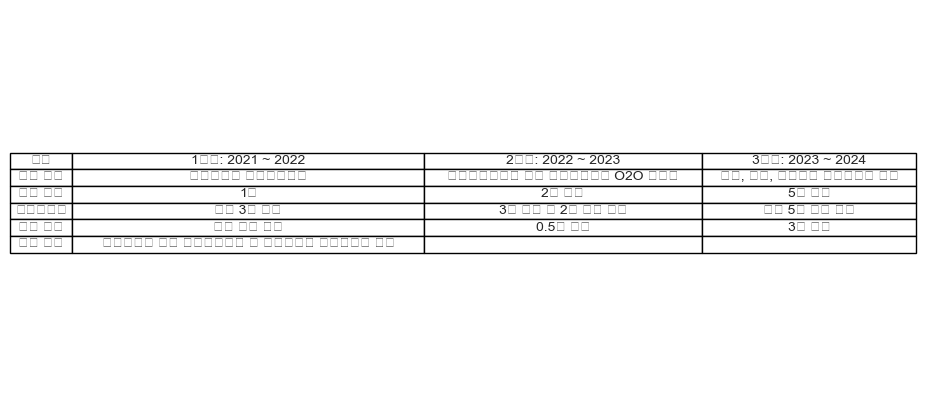

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

plt.rc('font', family='Malgun Gothic')

# 데이터 생성
data = {
    "구분": ["기술 내용", "신규 고용", "지식재산권", "예상 매출", "공동 개발"],
    "1단계: 2021 ~ 2022": [
        "나무의사용 전자진료차트",
        "1명",
        "특허 3건 출원",
        "개발 완료 단계",
        "세이버트리 주관 시야인사이트 및 한양대학교 공학대학원 참여"
    ],
    "2단계: 2022 ~ 2023": [
        "처방정보시스템 기반 수목의료용품 O2O 플랫폼",
        "2명 예정",
        "3건 등록 및 2건 출원 예정",
        "0.5억 예상",
        ""
    ],
    "3단계: 2023 ~ 2024": [
        "조경, 임업, 환경사업 입찰시스템 구축",
        "5명 예정",
        "특허 5건 등록 확보",
        "3억 예상",
        ""
    ]
}

# 데이터프레임 생성
df = pd.DataFrame(data)

# 그래프 스타일 설정
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# 테이블 생성
table = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# 테이블 스타일 조정
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2, 3])

# 축 숨기기
plt.axis('off')

# 이미지 저장
plt.savefig("table_image.png", dpi=300, bbox_inches='tight')
plt.show()


### gpt-3.5-turbo 고도화하여 4o모델 수준까지 끌어올리기
##### 1. rag 구축 
- 1-1. 사업계획서 작성과 관련된 데이터 수집(사업계획서 샘플, 평가기준, 가이드라인, 청창사 성공 사례, 사업계획서 실수하는 항목 정리 등 )
- 1-2. json, csv 또는 vectorDB로 저장- vectorDB를 사용할 계획(GPT-3.5가 입력 받을 때 관련 데이터를 검색하여 자동으로 제공)

##### 2. GPT-3.5와 데이터베이스 연결(RAG 적용)
- 2-1
- rag를 먼저 구축하면, 최신 데이터를 검색하여 gpt-3.5가 즉각적으로 활용하고 fine-tuning으로 rag를 보완해주면 좋다. 그리고 gpt-4o로 검토 및 수정

In [ ]:
from pathlib import Path

# ✅ 특정 폴더 경로 설정
folder_path = Path(r"C:/Users/MSI/Desktop/final project/kosme_file")

# ✅ 해당 폴더 내의 PDF 파일만 가져오기
pdf_files = list(folder_path.glob("*.pdf"))

# ✅ 가져온 파일 목록 확인
print("📂 가져온 PDF 파일 리스트:", pdf_files)


📂 가져온 PDF 파일 리스트: [WindowsPath('C:/Users/MSI/Desktop/final project/kosme_file/2022년+창업성공패키지+청년창업사관학교+신청서_.pdf'), WindowsPath('C:/Users/MSI/Desktop/final project/kosme_file/사업계획서 100번 써본 대표가 알려주는 사업계획서 합격 노하우.pdf')]


In [ ]:
pip install PyPDF2


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# NLTK의 punkt tokenizer 다운로드 (처음 한 번만 실행)
nltk.download('punkt')

In [ ]:
pip install langchain-chroma

In [ ]:
# Langchain에서 지원해주는 Chroma 클래스 임포트
from langchain_chroma import Chroma

# Langchain과 연동된 openai에서 지원하는 pre-trained Embedding 모델 활용
from langchain_openai import OpenAIEmbeddings

In [ ]:
# 임베딩 설정
my_embedding = OpenAIEmbeddings(model = "text-embedding-3-small",
                                api_key = MY_API_KEY
                                )

In [ ]:
import os
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.vectorstores import Chroma

# PDF 파일이 있는 디렉토리 경로
pdf_directory = 'C:/Users/MSI/Desktop/final project/kosme_file'
my_directory = 'VectorStores/'

# 청킹 설정
chunk_size = 200  # 분할된 텍스트의 최대 길이
chunk_overlap = 5  # 텍스트 조각 간의 겹치는 부분의 길이

# RecursiveCharacterTextSplitter 초기화
csv_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

# 디렉토리 내의 모든 PDF 파일 읽기
documents = []
for filename in os.listdir(pdf_directory):
    if filename.endswith('.pdf'):  # PDF 파일만 선택
        pdf_file_path = os.path.join(pdf_directory, filename)

        # PDF 파일 읽기
        with open(pdf_file_path, 'rb') as file:
            reader = PdfReader(file)
            text = ""
            
            # 모든 페이지의 텍스트를 하나의 문자열로 결합
            for page in reader.pages:
                text += page.extract_text() + "\n"

        # 텍스트를 청킹
        chunks = csv_splitter.split_text(text)

        # 청킹된 텍스트를 Document 객체로 변환
        for chunk in chunks:
            documents.append(Document(page_content=chunk, metadata={"source": filename}))

print("청크 개수 :", len(chunks))

# Chroma DB 생성
vectordb = Chroma.from_documents(documents=documents, embedding=my_embedding, persist_directory=my_directory)

# 결과 출력
print("Chroma DB가 성공적으로 생성되었습니다.")


청크 개수 : 81
Chroma DB가 성공적으로 생성되었습니다.


In [ ]:
vectordb._collection.count()

81

In [ ]:
# 모든 데이터 삭제
vectordb.delete_collection()

In [ ]:
question = "사업계획서 잘 쓰는 방법은?"

# similarity_search : 유사도 검색 실행 함수
 # k : 반환 받고자하는 document 객체 수 지정(청크 수)
 # (k값이 너무 크면 연관성이 떨어지는 문서까지 광범위하게 검색되어 정확성이 낮아질 수 있음)
similar_docs = vectordb.similarity_search(question, k=3)

print("객체 수 :", len(similar_docs))
print(similar_docs)

객체 수 : 3
[Document(metadata={'source': '사업계획서 100번 써본 대표가 알려주는 사업계획서 합격 노하우.pdf'}, page_content='사 업 계 획 서  작 성 은 ,  최 대 한  구 체 적 으 로 !'), Document(metadata={'source': '사업계획서 100번 써본 대표가 알려주는 사업계획서 합격 노하우.pdf'}, page_content='김 정 현신 해 람사업계획서 100번 써본 대표가 알려주는 사업계획서 합격 노하우\n\n정 부 지 원 사 업  소 개\n\n정 부 지 원 사 업  지 원  시 ,\n꼭  확 인 해 야  하 는  홈 페 이 지  및  채 널\nK 스 타 트 업\n스 타 트 업  플 러 스\n기 업 마 당\n판 판 대 로\nR I P C  지 역 지 식 재 산 센 터'), Document(metadata={'source': '사업계획서 100번 써본 대표가 알려주는 사업계획서 합격 노하우.pdf'}, page_content='모 바 일  게 임  창 업 의  경 우  사 업 계 획 서 를  어 떤  식 으 로  작 성 하 면  좋 을 까 요 ?모 바 일  게 임 의  경 우 ,  \n사 업 계 획 서 를  쓰 실  때 는   합 니 다 .')]


### 할 일은..?

In [ ]:
streamlit에서 입력값 받고 그게 jsonl로 저장
jsonl 불러와서 딕셔너리로 저장한 다음 초안 작성 코드 실행